# ***Section Who Grade Binary Classification***

This notebook shows the process of classifying section samples into binary who grade (high grade, low grade).

### ***Import packages***

Before we begin, let's import all the necessary packages for this notebook:

In [1]:
import gc
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from typing import Tuple
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from sklearn import metrics
from sklearn.model_selection import train_test_split
from skimage import (filters)
from tqdm import tqdm
from pyimzml.ImzMLParser import ImzMLParser

### ***Constants definitions***

Next, let's define some constant variables for this notebook:

In [2]:
# Define folder that contains the dhg dataset
DHG_PATH = "./../../../DHG/"
# Define folder that contains the preprocessed dataset
DATA_IN_PATH = f"{DHG_PATH}/preprocessed"
# Define file that contains dhg metadata
METADATA_PATH = f"{DHG_PATH}/metadata.csv"
# Define folder to save classification models for later use
MODELS_PATH = f"{DHG_PATH}/models/section/binary_who_grade_classification"
# Classification model number of epochs
EPHOCS = 100
# Classification model batch size
BATCH_SIZE = 256
# Classification model learning rate
LEARNING_RATE = 1e-3
# MSI Spectra dimension
SPECTRA_DIM = 92000
# The MSI sample type for filtering
SAMPLE_TYPE = "section"
# Mz value to get in order to threshold for tissue
TRESH_MZ = 750
# Mz tolerance value to get in order to threshold for tissue
TRESH_MZ_TOL = 150

### ***Define function to read a MSI***

Next, let's define a function to read a MSI:

In [3]:
def read_msi(p: ImzMLParser) -> Tuple[np.ndarray, np.ndarray]:
  """
    Function to read a continuos imzML parser object into a numpy array.

    Args:
        p (ImzMLParser): The imzML parser.
    Returns:
        Tuple[np.ndarray, np.ndarray]: Numpy 3D matrix where y coordinate
            (axis=0), x coordinate (axis=1), intensities values (axis=2)
            and continuos mzs values.

    """
  # Get shape of mzs values
  max_z = p.mzLengths[0]
  # Get shape of y axis
  max_y = p.imzmldict["max count of pixels y"]
  # Get shape of x axis
  max_x = p.imzmldict["max count of pixels x"]
  # Create empty numpy 3D matrix
  msi = np.zeros((max_y, max_x, max_z))
  # Loop over each coordinate and add to 3D matrix
  for i, (x, y, _) in enumerate(p.coordinates):
    # Get mzs and intenisties
    mzs, ints = p.getspectrum(i)
    # Add intensities to x,y coordinate
    msi[y - 1, x - 1, :] = ints
  return mzs, msi

### ***Reading MSI metadata file***

Next, let's read the metadata file:

In [4]:
# Read clinical state annotations csv
metadata_df = pd.read_csv(METADATA_PATH)

# Filter by sample_type
metadata_df = metadata_df[metadata_df["sample_type"] == SAMPLE_TYPE]

### ***Get single spectra information from all MSI:***

Next, let's get all information except intensities (which needs a lot of memory) for each spectra from all MSI:

In [5]:
# Create dict's to store each sample spectra's mean and std
# for non-tissue spectra's
sample_non_tissue_mean = {}
sample_non_tissue_std = {}

# Create lists to store each spectra's info
file_names = []
sample_numbers = []
histologies = []
who_grades = []
x_coordinates = []
y_coordinates = []
idxs = []
is_tissue = []

# Loop over each MSI
for index, row in tqdm(
    metadata_df.iterrows(), total=metadata_df.shape[0], desc="MSI Loop"
):
  # Parse the MSI file
  with ImzMLParser(
      os.path.join(DATA_IN_PATH, f"{row.sample_file_name}.imzML")
  ) as reader:
    # Get full msi
    mzs, data = read_msi(reader)

    # Get local TIC image of msi in range [600, 900] (X region)
    local_tic_img = data[:, :, ((mzs > (TRESH_MZ - TRESH_MZ_TOL))) &
                         (mzs < (TRESH_MZ + TRESH_MZ_TOL))].sum(axis=-1)

    # Threshold image to separate tissue spectra from background
    thresh_img = local_tic_img > filters.threshold_mean(local_tic_img)

    # Get non-tissue spectra's mean
    sample_non_tissue_mean[row.sample_file_name
                          ] = data[~thresh_img, :].mean(axis=0)
    # Get non-tissue spectra's std
    sample_non_tissue_std[row.sample_file_name
                         ] = data[~thresh_img, :].std(axis=0)

    # Loop over each spectra
    for idx, (x, y, z) in tqdm(
        enumerate(reader.coordinates), total=len(reader.coordinates),
        desc="Spectra Loop"
    ):
      # Keep sample file name of spectra
      file_names.append(row.sample_file_name)
      # Keep sample number of spectra
      sample_numbers.append(row.sample_number)
      # Keep sample histology of spectra
      histologies.append(row.histology)
      # Keep sample who grade of spectra
      who_grades.append(row.who_grade)
      # Keep x coordinate of spectra
      x_coordinates.append(x)
      # Keep y coordinate of spectra
      y_coordinates.append(y)
      # Keep  of spectra
      idxs.append(idx)
      # Check if spectra is tissue
      if thresh_img[y - 1, x - 1]:
        # Keep boolean indication on if spectra is tissue
        is_tissue.append(True)
      else:
        # Keep boolean indication on if spectra is not tissue
        is_tissue.append(False)

# Convert to numpy array
file_names = np.array(file_names)
sample_numbers = np.array(sample_numbers)
histologies = np.array(histologies)
who_grades = np.array(who_grades)
x_coordinates = np.array(x_coordinates)
y_coordinates = np.array(y_coordinates)
idxs = np.array(idxs)
is_tissue = np.array(is_tissue)
labels = (who_grades > 2).astype(int)

MSI Loop: 100%|██████████| 24/24 [01:06<00:00,  2.77s/it]


### ***MSI parsers opening:***

Next, let's create parser for each MSI in order to read spectra's for the model:

In [6]:
# Opening parsers
parsers = {
    file_name: ImzMLParser(os.path.join(DATA_IN_PATH, f"{file_name}.imzML"))
    for file_name in metadata_df.sample_file_name.unique()
}

### ***Dataset generator:***

Next, let's create a dataset generator for the model:

In [7]:
def map_index(index: tf.Tensor,
              standardize: tf.Tensor) -> Tuple[np.ndarray, int]:
  """Function to map index to model input (spectra) and output (label).

  Args:
      index (tf.Tensor): index to map to corresponding values.
      standardize (tf.Tensor): flag to determine standardization applying.

  Returns:
      Tuple[np.ndarray, int]: input (spectra) and output (label).
  
  """
  # Decoding from the EagerTensor object
  index, standardize = index.numpy(), standardize.numpy()
  # Reading spectra from parser
  file_name = file_names[index]
  idx = idxs[index]
  _, spectra = parsers[file_name].getspectrum(idx)
  # Apply standardization
  if standardize:
    spectra = (
        (spectra - sample_non_tissue_mean[file_name]) /
        sample_non_tissue_std[file_name]
    )

  # Return spectra and label
  return (spectra, labels[index])


def _fixup_shape(x: tf.Tensor, y: tf.Tensor):
  """ Function to Fix the implicit inferring of the shapes of the
  output Tensors.

  Args:
      x (tf.Tensor): input (spectra)
      y (tf.Tensor): output (label)

  Returns:
      Tuple[np.ndarray, np.ndarray]: input (spectra) and output (label) with
        correct shape.
  
  """
  x.set_shape([SPECTRA_DIM])
  y.set_shape([])
  return x, y


def create_ds(
    indexes: np.ndarray, batch_size: int, standardize: bool
) -> tf.data.Dataset:
  """Function to create a dataset for model

  Args:
      indexes (np.ndarray): indexes of thh dataset
      batch_size (int): batch size
      standardize (bool): flag to determine standardization applying.

  Returns:
      tf.data.Dataset: dataset
  """
  # Create dataset from indexes
  ds = tf.data.Dataset.from_tensor_slices(indexes)
  # Shuffle the data
  ds = ds.shuffle(len(indexes))
  # Map index to spectra
  ds = ds.map(
      lambda i: tf.py_function(
          func=map_index, inp=[i, standardize], Tout=[tf.float32, tf.float32]
      )
  )
  # Fix the implicit inferring of the shapes of the
  # output Tensors
  ds = ds.map(_fixup_shape)
  # Batch the spectra's
  ds = ds.batch(batch_size)
  # Prefetch batchs to make sure that a batch is ready to
  # be served at all time
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

### ***Classification model:***

Next, let's create a classification dense neural network model:

In [8]:
def get_model() -> tf.keras.Model:
  """Function to generate classification model.

  Returns:
      tf.keras.Model: classification model.
  
  """
  return tf.keras.Sequential(
    [
      layers.InputLayer(input_shape=(SPECTRA_DIM,)),
      layers.Dropout(0.5),
      layers.Dense(1024),
      layers.ReLU(),
      layers.BatchNormalization(),
      layers.Dropout(0.3),
      layers.Dense(1024),
      layers.ReLU(),
      layers.BatchNormalization(),
      layers.Dropout(0.3),
      layers.Dense(512),
      layers.ReLU(),
      layers.BatchNormalization(),
      layers.Dropout(0.3),
      layers.Dense(1, activation='sigmoid')
    ]
  )

### ***Approach 1 - Leave one sample out + no standardization:***

##### ***Training:***
Next, let"s create a classification model for each leave one sample out option:

In [9]:
train_metrics = {}
validation_metrics = {}

# Loop over each sample number
for exclude_sample in tqdm(np.unique(sample_numbers)):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Create filter for training data - does not include the excluded sample
  # and only include tissue spectra's
  train_filter = ((sample_numbers != exclude_sample) & is_tissue)

  # Get indexes of all data
  indexes = np.arange(len(sample_numbers))

  # Get indexes of training data
  train_indexes = indexes[train_filter]

  # Get indexes of training and validation data
  train_indexes, val_indexes = train_test_split(
      train_indexes, test_size=0.2, random_state=0,
      stratify=labels[train_filter]
  )

  # Create data generators
  train_generator = create_ds(train_indexes, BATCH_SIZE, False)
  validation_generator = create_ds(val_indexes, BATCH_SIZE, False)

  # Create Callback to save the best model
  checkpoint_filepath = os.path.join(
      '.', f"approach_1/excluded_{exclude_sample}/"
  )
  model_checkpoint_callback = callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath, save_weights_only=False,
      monitor="val_binary_accuracy", mode="max", save_best_only=True
  )

  # Create Callback for model early stopping
  model_es_callback = callbacks.EarlyStopping(
      monitor='val_loss', mode='min', verbose=1, patience=5, min_delta=0.0001
  )

  # Create classification model
  classification_model = get_model()

  # Compile the classification model
  optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
  classification_model.compile(
      optimizer, loss=losses.BinaryCrossentropy(), metrics=["binary_accuracy"]
  )

  # Train the classification model
  history = classification_model.fit(
      x=train_generator, validation_data=validation_generator, epochs=EPHOCS,
      callbacks=[model_checkpoint_callback, model_es_callback]
  )

  # Load the best saved
  classification_model = tf.keras.models.load_model(checkpoint_filepath)

  # Evaluate on train and validation
  train_metrics[exclude_sample] = classification_model.evaluate(
      x=train_generator
  )
  validation_metrics[exclude_sample] = classification_model.evaluate(
      x=validation_generator
  )

  # Clean model for next iteration
  classification_model = None

  # Separate training
  print("#" * 30)

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 1/100
84/84 [==============================] - 23s 252ms/step - loss: 0.0598 - binary_accuracy: 0.9777 - val_loss: 0.7187 - val_binary_accuracy: 0.6517
INFO:tensorflow:Assets written to: .\approach_1/excluded_2\assets
Epoch 2/100
84/84 [==============================] - 21s 248ms/step - loss: 0.0075 - binary_accuracy: 0.9976 - val_loss: 0.8876 - val_binary_accuracy: 0.6517
Epoch 3/100
84/84 [==============================] - 20s 241ms/step - loss: 0.0050 - binary_accuracy: 0.9984 - val_loss: 0.9057 - val_binary_accuracy: 0.6517
Epoch 4/100
84/84 [==============================] - 20s 242ms/step - loss: 0.0014 - binary_accuracy: 0.9996 - val_loss: 0.9010 - val_binary_accuracy: 0.6517
Epoch 5/100
84/84 [==============================] - 20s 242ms/step - loss: 0.0029 - binary_accuracy: 0.9992 - val_loss: 0.5291 - val_binary_accuracy: 0.6643
INFO:tensorflow:Assets written to: .\approach_1/excluded_2\assets
Epoch 6/100
84/84 [==============================] - 21s 252ms/step - loss: 0.

  5%|▍         | 1/22 [05:50<2:02:36, 350.32s/it]

##############################
Epoch 1/100
83/83 [==============================] - 20s 235ms/step - loss: 0.0998 - binary_accuracy: 0.9673 - val_loss: 0.6683 - val_binary_accuracy: 0.6225
INFO:tensorflow:Assets written to: .\approach_1/excluded_3\assets
Epoch 2/100
83/83 [==============================] - 21s 252ms/step - loss: 0.0073 - binary_accuracy: 0.9973 - val_loss: 0.6803 - val_binary_accuracy: 0.6225
Epoch 3/100
83/83 [==============================] - 20s 245ms/step - loss: 0.0043 - binary_accuracy: 0.9986 - val_loss: 0.6319 - val_binary_accuracy: 0.6225
Epoch 4/100
83/83 [==============================] - 19s 232ms/step - loss: 0.0034 - binary_accuracy: 0.9988 - val_loss: 0.5618 - val_binary_accuracy: 0.6227
INFO:tensorflow:Assets written to: .\approach_1/excluded_3\assets
Epoch 5/100
83/83 [==============================] - 21s 246ms/step - loss: 0.0014 - binary_accuracy: 0.9997 - val_loss: 0.3695 - val_binary_accuracy: 0.8886
INFO:tensorflow:Assets written to: .\approach_1

  9%|▉         | 2/22 [12:34<2:07:14, 381.75s/it]

##############################
Epoch 1/100
83/83 [==============================] - 23s 273ms/step - loss: 0.0968 - binary_accuracy: 0.9638 - val_loss: 0.6604 - val_binary_accuracy: 0.6243
INFO:tensorflow:Assets written to: .\approach_1/excluded_4\assets
Epoch 2/100
83/83 [==============================] - 22s 265ms/step - loss: 0.0067 - binary_accuracy: 0.9978 - val_loss: 0.6584 - val_binary_accuracy: 0.6243
Epoch 3/100
83/83 [==============================] - 19s 230ms/step - loss: 0.0025 - binary_accuracy: 0.9992 - val_loss: 0.6293 - val_binary_accuracy: 0.6243
Epoch 4/100
83/83 [==============================] - 20s 242ms/step - loss: 0.0041 - binary_accuracy: 0.9987 - val_loss: 0.5579 - val_binary_accuracy: 0.6254
INFO:tensorflow:Assets written to: .\approach_1/excluded_4\assets
Epoch 5/100
83/83 [==============================] - 21s 248ms/step - loss: 0.0031 - binary_accuracy: 0.9992 - val_loss: 0.3579 - val_binary_accuracy: 0.8802
INFO:tensorflow:Assets written to: .\approach_1

 14%|█▎        | 3/22 [19:07<2:02:34, 387.06s/it]

##############################
Epoch 1/100
84/84 [==============================] - 22s 254ms/step - loss: 0.1006 - binary_accuracy: 0.9666 - val_loss: 0.6792 - val_binary_accuracy: 0.6286
INFO:tensorflow:Assets written to: .\approach_1/excluded_5\assets
Epoch 2/100
84/84 [==============================] - 21s 252ms/step - loss: 0.0085 - binary_accuracy: 0.9975 - val_loss: 0.6869 - val_binary_accuracy: 0.6286
Epoch 3/100
84/84 [==============================] - 21s 244ms/step - loss: 0.0040 - binary_accuracy: 0.9986 - val_loss: 0.6907 - val_binary_accuracy: 0.6286
Epoch 4/100
84/84 [==============================] - 21s 251ms/step - loss: 0.0021 - binary_accuracy: 0.9994 - val_loss: 0.6378 - val_binary_accuracy: 0.6286
Epoch 5/100
84/84 [==============================] - 20s 241ms/step - loss: 0.0012 - binary_accuracy: 0.9996 - val_loss: 0.4655 - val_binary_accuracy: 0.6705
INFO:tensorflow:Assets written to: .\approach_1/excluded_5\assets
Epoch 6/100
84/84 [============================

 18%|█▊        | 4/22 [25:38<1:56:33, 388.55s/it]

##############################
Epoch 1/100
84/84 [==============================] - 22s 258ms/step - loss: 0.0972 - binary_accuracy: 0.9652 - val_loss: 0.6611 - val_binary_accuracy: 0.6274
INFO:tensorflow:Assets written to: .\approach_1/excluded_6\assets
Epoch 2/100
84/84 [==============================] - 21s 252ms/step - loss: 0.0058 - binary_accuracy: 0.9978 - val_loss: 0.6576 - val_binary_accuracy: 0.6274
Epoch 3/100
84/84 [==============================] - 22s 262ms/step - loss: 0.0038 - binary_accuracy: 0.9987 - val_loss: 0.6130 - val_binary_accuracy: 0.6274
Epoch 4/100
84/84 [==============================] - 22s 262ms/step - loss: 0.0028 - binary_accuracy: 0.9989 - val_loss: 0.5480 - val_binary_accuracy: 0.6946
INFO:tensorflow:Assets written to: .\approach_1/excluded_6\assets
Epoch 5/100
84/84 [==============================] - 20s 237ms/step - loss: 0.0034 - binary_accuracy: 0.9989 - val_loss: 0.3481 - val_binary_accuracy: 0.9816
INFO:tensorflow:Assets written to: .\approach_1

 23%|██▎       | 5/22 [31:49<1:48:16, 382.17s/it]

##############################
Epoch 1/100
84/84 [==============================] - 23s 261ms/step - loss: 0.0998 - binary_accuracy: 0.9638 - val_loss: 0.6919 - val_binary_accuracy: 0.6271
INFO:tensorflow:Assets written to: .\approach_1/excluded_7\assets
Epoch 2/100
84/84 [==============================] - 22s 258ms/step - loss: 0.0076 - binary_accuracy: 0.9978 - val_loss: 0.7761 - val_binary_accuracy: 0.6271
Epoch 3/100
84/84 [==============================] - 21s 250ms/step - loss: 0.0028 - binary_accuracy: 0.9992 - val_loss: 0.8399 - val_binary_accuracy: 0.6271
Epoch 4/100
84/84 [==============================] - 22s 258ms/step - loss: 0.0018 - binary_accuracy: 0.9994 - val_loss: 0.7375 - val_binary_accuracy: 0.6271
Epoch 5/100
84/84 [==============================] - 21s 249ms/step - loss: 0.0017 - binary_accuracy: 0.9995 - val_loss: 0.4698 - val_binary_accuracy: 0.6605
INFO:tensorflow:Assets written to: .\approach_1/excluded_7\assets
Epoch 6/100
84/84 [============================

 27%|██▋       | 6/22 [38:23<1:43:01, 386.35s/it]

##############################
Epoch 1/100
79/79 [==============================] - 20s 240ms/step - loss: 0.0926 - binary_accuracy: 0.9666 - val_loss: 0.6703 - val_binary_accuracy: 0.6054
INFO:tensorflow:Assets written to: .\approach_1/excluded_8\assets
Epoch 2/100
79/79 [==============================] - 20s 251ms/step - loss: 0.0050 - binary_accuracy: 0.9984 - val_loss: 0.6673 - val_binary_accuracy: 0.6054
Epoch 3/100
79/79 [==============================] - 20s 248ms/step - loss: 0.0031 - binary_accuracy: 0.9993 - val_loss: 0.6342 - val_binary_accuracy: 0.6054
Epoch 4/100
79/79 [==============================] - 20s 252ms/step - loss: 0.0028 - binary_accuracy: 0.9991 - val_loss: 0.5438 - val_binary_accuracy: 0.6209
INFO:tensorflow:Assets written to: .\approach_1/excluded_8\assets
Epoch 5/100
79/79 [==============================] - 20s 253ms/step - loss: 0.0023 - binary_accuracy: 0.9992 - val_loss: 0.4126 - val_binary_accuracy: 0.7627
INFO:tensorflow:Assets written to: .\approach_1

 32%|███▏      | 7/22 [43:47<1:31:29, 365.96s/it]

##############################
Epoch 1/100
84/84 [==============================] - 22s 249ms/step - loss: 0.1059 - binary_accuracy: 0.9647 - val_loss: 0.6575 - val_binary_accuracy: 0.6272
INFO:tensorflow:Assets written to: .\approach_1/excluded_9\assets
Epoch 2/100
84/84 [==============================] - 23s 270ms/step - loss: 0.0061 - binary_accuracy: 0.9980 - val_loss: 0.6503 - val_binary_accuracy: 0.6272
Epoch 3/100
84/84 [==============================] - 21s 251ms/step - loss: 0.0045 - binary_accuracy: 0.9985 - val_loss: 0.6080 - val_binary_accuracy: 0.6272
Epoch 4/100
84/84 [==============================] - 20s 243ms/step - loss: 0.0015 - binary_accuracy: 0.9997 - val_loss: 0.5170 - val_binary_accuracy: 0.6420
INFO:tensorflow:Assets written to: .\approach_1/excluded_9\assets
Epoch 5/100
84/84 [==============================] - 21s 247ms/step - loss: 0.0014 - binary_accuracy: 0.9995 - val_loss: 0.4031 - val_binary_accuracy: 0.7323
INFO:tensorflow:Assets written to: .\approach_1

 36%|███▋      | 8/22 [49:56<1:25:38, 367.02s/it]

##############################
Epoch 1/100
83/83 [==============================] - 21s 247ms/step - loss: 0.0971 - binary_accuracy: 0.9637 - val_loss: 0.6571 - val_binary_accuracy: 0.6233
INFO:tensorflow:Assets written to: .\approach_1/excluded_10\assets
Epoch 2/100
83/83 [==============================] - 21s 255ms/step - loss: 0.0065 - binary_accuracy: 0.9980 - val_loss: 0.6508 - val_binary_accuracy: 0.6233
Epoch 3/100
83/83 [==============================] - 21s 254ms/step - loss: 0.0031 - binary_accuracy: 0.9990 - val_loss: 0.6310 - val_binary_accuracy: 0.6233
Epoch 4/100
83/83 [==============================] - 21s 253ms/step - loss: 0.0030 - binary_accuracy: 0.9990 - val_loss: 0.5555 - val_binary_accuracy: 0.9682
INFO:tensorflow:Assets written to: .\approach_1/excluded_10\assets
Epoch 5/100
83/83 [==============================] - 21s 254ms/step - loss: 0.0021 - binary_accuracy: 0.9993 - val_loss: 0.3922 - val_binary_accuracy: 0.9775
INFO:tensorflow:Assets written to: .\approach

 41%|████      | 9/22 [57:35<1:25:44, 395.75s/it]

##############################
Epoch 1/100
80/80 [==============================] - 22s 266ms/step - loss: 0.1100 - binary_accuracy: 0.9647 - val_loss: 0.6687 - val_binary_accuracy: 0.6113
INFO:tensorflow:Assets written to: .\approach_1/excluded_11\assets
Epoch 2/100
80/80 [==============================] - 22s 271ms/step - loss: 0.0075 - binary_accuracy: 0.9976 - val_loss: 0.6778 - val_binary_accuracy: 0.6113
Epoch 3/100
80/80 [==============================] - 20s 250ms/step - loss: 0.0025 - binary_accuracy: 0.9993 - val_loss: 0.6489 - val_binary_accuracy: 0.6113
Epoch 4/100
80/80 [==============================] - 21s 258ms/step - loss: 0.0029 - binary_accuracy: 0.9992 - val_loss: 0.5793 - val_binary_accuracy: 0.6113
Epoch 5/100
80/80 [==============================] - 21s 260ms/step - loss: 0.0037 - binary_accuracy: 0.9988 - val_loss: 0.4092 - val_binary_accuracy: 0.7389
INFO:tensorflow:Assets written to: .\approach_1/excluded_11\assets
Epoch 6/100
80/80 [==========================

 45%|████▌     | 10/22 [1:04:36<1:20:42, 403.51s/it]

##############################
Epoch 1/100
78/78 [==============================] - 20s 248ms/step - loss: 0.1183 - binary_accuracy: 0.9592 - val_loss: 0.6757 - val_binary_accuracy: 0.5967
INFO:tensorflow:Assets written to: .\approach_1/excluded_12\assets
Epoch 2/100
78/78 [==============================] - 20s 259ms/step - loss: 0.0082 - binary_accuracy: 0.9977 - val_loss: 0.6735 - val_binary_accuracy: 0.5967
Epoch 3/100
78/78 [==============================] - 20s 251ms/step - loss: 0.0039 - binary_accuracy: 0.9989 - val_loss: 0.6441 - val_binary_accuracy: 0.8968
INFO:tensorflow:Assets written to: .\approach_1/excluded_12\assets
Epoch 4/100
78/78 [==============================] - 20s 262ms/step - loss: 0.0022 - binary_accuracy: 0.9994 - val_loss: 0.5823 - val_binary_accuracy: 0.9947
INFO:tensorflow:Assets written to: .\approach_1/excluded_12\assets
Epoch 5/100
78/78 [==============================] - 20s 247ms/step - loss: 0.0098 - binary_accuracy: 0.9973 - val_loss: 0.4656 - val_bi

 50%|█████     | 11/22 [1:11:00<1:12:53, 397.62s/it]

##############################
Epoch 1/100
82/82 [==============================] - 21s 247ms/step - loss: 0.1050 - binary_accuracy: 0.9653 - val_loss: 0.6618 - val_binary_accuracy: 0.6191
INFO:tensorflow:Assets written to: .\approach_1/excluded_13\assets
Epoch 2/100
82/82 [==============================] - 22s 265ms/step - loss: 0.0059 - binary_accuracy: 0.9983 - val_loss: 0.6508 - val_binary_accuracy: 0.6191
Epoch 3/100
82/82 [==============================] - 20s 243ms/step - loss: 0.0036 - binary_accuracy: 0.9990 - val_loss: 0.6320 - val_binary_accuracy: 0.6191
Epoch 4/100
82/82 [==============================] - 21s 258ms/step - loss: 0.0026 - binary_accuracy: 0.9991 - val_loss: 0.5484 - val_binary_accuracy: 0.6574
INFO:tensorflow:Assets written to: .\approach_1/excluded_13\assets
Epoch 5/100
82/82 [==============================] - 21s 248ms/step - loss: 0.0018 - binary_accuracy: 0.9995 - val_loss: 0.4056 - val_binary_accuracy: 0.7964
INFO:tensorflow:Assets written to: .\approach

 55%|█████▍    | 12/22 [1:16:48<1:03:42, 382.28s/it]

##############################
Epoch 1/100
80/80 [==============================] - 21s 255ms/step - loss: 0.0955 - binary_accuracy: 0.9661 - val_loss: 0.6700 - val_binary_accuracy: 0.6078
INFO:tensorflow:Assets written to: .\approach_1/excluded_14\assets
Epoch 2/100
80/80 [==============================] - 19s 238ms/step - loss: 0.0058 - binary_accuracy: 0.9981 - val_loss: 0.6747 - val_binary_accuracy: 0.6078
Epoch 3/100
80/80 [==============================] - 20s 246ms/step - loss: 0.0039 - binary_accuracy: 0.9988 - val_loss: 0.6339 - val_binary_accuracy: 0.6078
Epoch 4/100
80/80 [==============================] - 20s 245ms/step - loss: 0.0034 - binary_accuracy: 0.9990 - val_loss: 0.5946 - val_binary_accuracy: 0.6078
Epoch 5/100
80/80 [==============================] - 20s 242ms/step - loss: 0.0025 - binary_accuracy: 0.9991 - val_loss: 0.4260 - val_binary_accuracy: 0.7645
INFO:tensorflow:Assets written to: .\approach_1/excluded_14\assets
Epoch 6/100
80/80 [==========================

 59%|█████▉    | 13/22 [1:23:01<56:55, 379.50s/it]  

##############################
Epoch 1/100
82/82 [==============================] - 21s 243ms/step - loss: 0.0749 - binary_accuracy: 0.9752 - val_loss: 0.6847 - val_binary_accuracy: 0.6195
INFO:tensorflow:Assets written to: .\approach_1/excluded_15\assets
Epoch 2/100
82/82 [==============================] - 20s 244ms/step - loss: 0.0035 - binary_accuracy: 0.9994 - val_loss: 0.7405 - val_binary_accuracy: 0.6195
Epoch 3/100
82/82 [==============================] - 21s 252ms/step - loss: 0.0017 - binary_accuracy: 0.9995 - val_loss: 0.7193 - val_binary_accuracy: 0.6195
Epoch 4/100
82/82 [==============================] - 21s 251ms/step - loss: 0.0013 - binary_accuracy: 0.9997 - val_loss: 0.6091 - val_binary_accuracy: 0.6195
Epoch 5/100
82/82 [==============================] - 20s 241ms/step - loss: 7.7442e-04 - binary_accuracy: 0.9997 - val_loss: 0.5264 - val_binary_accuracy: 0.6205
INFO:tensorflow:Assets written to: .\approach_1/excluded_15\assets
Epoch 6/100
82/82 [======================

 64%|██████▎   | 14/22 [1:28:56<49:36, 372.04s/it]

##############################
Epoch 1/100
82/82 [==============================] - 21s 244ms/step - loss: 0.0907 - binary_accuracy: 0.9640 - val_loss: 0.6356 - val_binary_accuracy: 0.6675
INFO:tensorflow:Assets written to: .\approach_1/excluded_16\assets
Epoch 2/100
82/82 [==============================] - 21s 254ms/step - loss: 0.0069 - binary_accuracy: 0.9978 - val_loss: 0.6292 - val_binary_accuracy: 0.6675
Epoch 3/100
82/82 [==============================] - 20s 244ms/step - loss: 0.0035 - binary_accuracy: 0.9987 - val_loss: 0.6063 - val_binary_accuracy: 0.6675
Epoch 4/100
82/82 [==============================] - 20s 245ms/step - loss: 0.0022 - binary_accuracy: 0.9995 - val_loss: 0.5650 - val_binary_accuracy: 0.6677
INFO:tensorflow:Assets written to: .\approach_1/excluded_16\assets
Epoch 5/100
82/82 [==============================] - 20s 243ms/step - loss: 0.0022 - binary_accuracy: 0.9994 - val_loss: 0.3822 - val_binary_accuracy: 0.9304
INFO:tensorflow:Assets written to: .\approach

 68%|██████▊   | 15/22 [1:34:42<42:29, 364.28s/it]

##############################
Epoch 1/100
83/83 [==============================] - 23s 268ms/step - loss: 0.1033 - binary_accuracy: 0.9654 - val_loss: 0.6522 - val_binary_accuracy: 0.6588
INFO:tensorflow:Assets written to: .\approach_1/excluded_18\assets
Epoch 2/100
83/83 [==============================] - 22s 260ms/step - loss: 0.0051 - binary_accuracy: 0.9987 - val_loss: 0.7087 - val_binary_accuracy: 0.6588
Epoch 3/100
83/83 [==============================] - 22s 259ms/step - loss: 0.0030 - binary_accuracy: 0.9990 - val_loss: 0.7333 - val_binary_accuracy: 0.6588
Epoch 4/100
83/83 [==============================] - 21s 247ms/step - loss: 0.0026 - binary_accuracy: 0.9992 - val_loss: 0.6269 - val_binary_accuracy: 0.6588
Epoch 5/100
83/83 [==============================] - 22s 259ms/step - loss: 0.0035 - binary_accuracy: 0.9993 - val_loss: 0.5131 - val_binary_accuracy: 0.6700
INFO:tensorflow:Assets written to: .\approach_1/excluded_18\assets
Epoch 6/100
83/83 [==========================

 73%|███████▎  | 16/22 [1:40:02<35:05, 350.92s/it]

##############################
Epoch 1/100
84/84 [==============================] - 22s 250ms/step - loss: 0.0907 - binary_accuracy: 0.9666 - val_loss: 0.6462 - val_binary_accuracy: 0.6520
INFO:tensorflow:Assets written to: .\approach_1/excluded_19\assets
Epoch 2/100
84/84 [==============================] - 22s 264ms/step - loss: 0.0069 - binary_accuracy: 0.9977 - val_loss: 0.6484 - val_binary_accuracy: 0.6520
Epoch 3/100
84/84 [==============================] - 22s 262ms/step - loss: 0.0030 - binary_accuracy: 0.9993 - val_loss: 0.6208 - val_binary_accuracy: 0.6520
Epoch 4/100
84/84 [==============================] - 22s 261ms/step - loss: 0.0061 - binary_accuracy: 0.9982 - val_loss: 0.5377 - val_binary_accuracy: 0.6527
INFO:tensorflow:Assets written to: .\approach_1/excluded_19\assets
Epoch 5/100
84/84 [==============================] - 21s 246ms/step - loss: 0.0035 - binary_accuracy: 0.9990 - val_loss: 0.3650 - val_binary_accuracy: 0.8858
INFO:tensorflow:Assets written to: .\approach

 77%|███████▋  | 17/22 [1:46:41<30:26, 365.31s/it]

##############################
Epoch 1/100
82/82 [==============================] - 22s 256ms/step - loss: 0.1019 - binary_accuracy: 0.9671 - val_loss: 0.6450 - val_binary_accuracy: 0.6687
INFO:tensorflow:Assets written to: .\approach_1/excluded_20\assets
Epoch 2/100
82/82 [==============================] - 20s 245ms/step - loss: 0.0055 - binary_accuracy: 0.9981 - val_loss: 0.6961 - val_binary_accuracy: 0.6687
Epoch 3/100
82/82 [==============================] - 21s 253ms/step - loss: 0.0041 - binary_accuracy: 0.9988 - val_loss: 0.6994 - val_binary_accuracy: 0.6687
Epoch 4/100
82/82 [==============================] - 21s 256ms/step - loss: 0.0021 - binary_accuracy: 0.9993 - val_loss: 0.6683 - val_binary_accuracy: 0.6687
Epoch 5/100
82/82 [==============================] - 21s 258ms/step - loss: 0.0022 - binary_accuracy: 0.9994 - val_loss: 0.5756 - val_binary_accuracy: 0.6687
Epoch 6/100
82/82 [==============================] - 20s 249ms/step - loss: 0.0018 - binary_accuracy: 0.9995 - v

 82%|████████▏ | 18/22 [1:55:19<27:25, 411.46s/it]

##############################
Epoch 1/100
81/81 [==============================] - 21s 244ms/step - loss: 0.0587 - binary_accuracy: 0.9775 - val_loss: 0.6612 - val_binary_accuracy: 0.6133
INFO:tensorflow:Assets written to: .\approach_1/excluded_21\assets
Epoch 2/100
81/81 [==============================] - 20s 247ms/step - loss: 0.0079 - binary_accuracy: 0.9972 - val_loss: 0.6431 - val_binary_accuracy: 0.6133
Epoch 3/100
81/81 [==============================] - 20s 252ms/step - loss: 0.0027 - binary_accuracy: 0.9991 - val_loss: 0.6067 - val_binary_accuracy: 0.6133
Epoch 4/100
81/81 [==============================] - 20s 247ms/step - loss: 0.0026 - binary_accuracy: 0.9991 - val_loss: 0.4958 - val_binary_accuracy: 0.9893
INFO:tensorflow:Assets written to: .\approach_1/excluded_21\assets
Epoch 5/100
81/81 [==============================] - 21s 255ms/step - loss: 0.0017 - binary_accuracy: 0.9995 - val_loss: 0.3091 - val_binary_accuracy: 0.9879
Epoch 6/100
81/81 [==========================

 86%|████████▋ | 19/22 [2:01:52<20:17, 405.73s/it]

##############################
Epoch 1/100
81/81 [==============================] - 22s 261ms/step - loss: 0.1187 - binary_accuracy: 0.9627 - val_loss: 0.6311 - val_binary_accuracy: 0.6744
INFO:tensorflow:Assets written to: .\approach_1/excluded_23\assets
Epoch 2/100
81/81 [==============================] - 20s 249ms/step - loss: 0.0051 - binary_accuracy: 0.9987 - val_loss: 0.6302 - val_binary_accuracy: 0.6744
Epoch 3/100
81/81 [==============================] - 19s 240ms/step - loss: 0.0031 - binary_accuracy: 0.9991 - val_loss: 0.6183 - val_binary_accuracy: 0.6744
Epoch 4/100
81/81 [==============================] - 20s 248ms/step - loss: 0.0019 - binary_accuracy: 0.9994 - val_loss: 0.5702 - val_binary_accuracy: 0.6744
Epoch 5/100
81/81 [==============================] - 20s 250ms/step - loss: 0.0013 - binary_accuracy: 0.9998 - val_loss: 0.4488 - val_binary_accuracy: 0.6865
INFO:tensorflow:Assets written to: .\approach_1/excluded_23\assets
Epoch 6/100
81/81 [==========================

 91%|█████████ | 20/22 [2:07:23<12:46, 383.48s/it]

##############################
Epoch 1/100
82/82 [==============================] - 22s 255ms/step - loss: 0.1104 - binary_accuracy: 0.9637 - val_loss: 0.6921 - val_binary_accuracy: 0.6649
INFO:tensorflow:Assets written to: .\approach_1/excluded_25\assets
Epoch 2/100
82/82 [==============================] - 21s 261ms/step - loss: 0.0067 - binary_accuracy: 0.9980 - val_loss: 0.8304 - val_binary_accuracy: 0.6649
Epoch 3/100
82/82 [==============================] - 22s 263ms/step - loss: 0.0026 - binary_accuracy: 0.9992 - val_loss: 0.9262 - val_binary_accuracy: 0.6649
Epoch 4/100
82/82 [==============================] - 21s 261ms/step - loss: 0.0017 - binary_accuracy: 0.9997 - val_loss: 0.9244 - val_binary_accuracy: 0.6649
Epoch 5/100
82/82 [==============================] - 21s 260ms/step - loss: 0.0035 - binary_accuracy: 0.9989 - val_loss: 0.6537 - val_binary_accuracy: 0.6649
Epoch 6/100
82/82 [==============================] - 21s 253ms/step - loss: 0.0021 - binary_accuracy: 0.9993 - v

 95%|█████████▌| 21/22 [2:13:25<06:17, 377.04s/it]

##############################
Epoch 1/100
79/79 [==============================] - 20s 247ms/step - loss: 0.1033 - binary_accuracy: 0.9630 - val_loss: 0.6150 - val_binary_accuracy: 0.6920
INFO:tensorflow:Assets written to: .\approach_1/excluded_29\assets
Epoch 2/100
79/79 [==============================] - 20s 251ms/step - loss: 0.0077 - binary_accuracy: 0.9979 - val_loss: 0.6101 - val_binary_accuracy: 0.6920
Epoch 3/100
79/79 [==============================] - 19s 241ms/step - loss: 0.0073 - binary_accuracy: 0.9973 - val_loss: 0.5998 - val_binary_accuracy: 0.6920
Epoch 4/100
79/79 [==============================] - 19s 245ms/step - loss: 0.0033 - binary_accuracy: 0.9993 - val_loss: 0.5849 - val_binary_accuracy: 0.7751
INFO:tensorflow:Assets written to: .\approach_1/excluded_29\assets
Epoch 5/100
79/79 [==============================] - 20s 257ms/step - loss: 0.0012 - binary_accuracy: 0.9995 - val_loss: 0.4371 - val_binary_accuracy: 0.9611
INFO:tensorflow:Assets written to: .\approach

100%|██████████| 22/22 [2:19:15<00:00, 379.78s/it]

##############################


In [10]:
train_metrics

{2: [0.0006267095450311899, 1.0],
 3: [0.0011956623056903481, 1.0],
 4: [6.460145868913969e-06, 1.0],
 5: [1.5750425518490374e-05, 1.0],
 6: [3.3124098990811035e-05, 1.0],
 7: [3.129552351310849e-05, 1.0],
 8: [0.00041702037560753524, 1.0],
 9: [2.572868197603384e-06, 1.0],
 10: [5.116211923450464e-06, 1.0],
 11: [8.832987987261731e-06, 1.0],
 12: [1.1312079550407361e-05, 1.0],
 13: [1.9363451428944245e-05, 1.0],
 14: [1.975720442715101e-05, 1.0],
 15: [1.3620258869195823e-05, 1.0],
 16: [0.00030741735827177763, 1.0],
 18: [0.0020456353668123484, 1.0],
 19: [4.572590842144564e-05, 1.0],
 20: [1.7629768990445882e-05, 1.0],
 21: [4.155853730480885e-06, 1.0],
 23: [0.00037810156936757267, 1.0],
 25: [2.3029884687275626e-05, 1.0],
 29: [0.00010474533337401226, 1.0]}

In [11]:
validation_metrics

{2: [0.003859149292111397, 0.9994367361068726],
 3: [0.004376837518066168, 0.9992411136627197],
 4: [0.0023670820519328117, 0.9994333386421204],
 5: [0.0015915855765342712, 0.9992531538009644],
 6: [0.0016546892002224922, 0.9994379878044128],
 7: [0.0015514484839513898, 0.999625027179718],
 8: [0.0021360116079449654, 0.999603271484375],
 9: [0.002199931535869837, 0.9996251463890076],
 10: [0.0009913365356624126, 0.9996214509010315],
 11: [0.0043223039247095585, 0.9988274574279785],
 12: [0.0012939074076712132, 0.9995946288108826],
 13: [0.0037584698293358088, 0.9992344379425049],
 14: [0.0009489133954048157, 0.9996055960655212],
 15: [0.0004035963211208582, 0.9998087286949158],
 16: [0.003750821342691779, 0.9986538290977478],
 18: [0.005514604039490223, 0.9988612532615662],
 19: [0.0045166234485805035, 0.999060869216919],
 20: [0.0018779553938657045, 0.9996147155761719],
 21: [0.0005697788437828422, 0.9998055696487427],
 23: [0.003555404720827937, 0.999028205871582],
 25: [0.0040362016

##### ***Evaluation on tissue spectra's:***

Next, let's get the prediction of each of left out sample spectra's:

In [12]:
# Define dict for saving predictions and true labels
predictions = {}
true_labels = {}

# Loop over each sample number
for exclude_sample in tqdm(np.unique(sample_numbers)):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Create filter for training data
  test_filter = ((sample_numbers == exclude_sample) & is_tissue)

  # Get indexes of all data
  indexes = np.arange(len(sample_numbers))

  # Create test data generator
  test_generator = create_ds(indexes[test_filter], BATCH_SIZE, False)

  # Get saved model path
  model_path = os.path.join(
      '.', f"approach_1/excluded_{exclude_sample}/"
  )

  # Load model
  classification_model = tf.keras.models.load_model(model_path)

  # Get predictions
  predictions[exclude_sample] = classification_model.predict(x=test_generator)

  # Get corresponding true labels
  true_labels[exclude_sample] = labels[test_filter]

  # Clean model for next iteration
  classification_model = None

 27%|██▋       | 6/22 [00:25<01:05,  4.09s/it]

100%|██████████| 22/22 [01:45<00:00,  4.79s/it]


Next, let's get some statistics about each left out sample predictions:

In [13]:
# Set pandas display format
pd.options.display.float_format = '{:.10f}'.format
# Create datafrmae of each sample left out
model_eval = pd.DataFrame({"sample_left_out": predictions.keys()})
# Get the minimum prediction value of each sample left out
model_eval["min_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].min())
# Get the maximum prediction value of each sample left out
model_eval["max_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].max())
# Get the median prediction value of each sample left out
model_eval["median_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: np.median(predictions[key]))
# Get the mean prediction value of each sample left out
model_eval["mean_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].mean())
# Get the standard deviation prediction value of each sample left out
model_eval["std_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].std())
# Get the sample prediction = majority rule of sample spectra's prediction
model_eval["sample_label"] = model_eval.sample_left_out.apply(
    lambda key: true_labels[key][0])
# Get the sample true label
model_eval["sample_prediction"] = (model_eval.mean_spectra_prediction >
                                   0.5).astype(int)
# Print statistics
model_eval

,sample_left_out,min_spectra_prediction,max_spectra_prediction,median_spectra_prediction,mean_spectra_prediction,std_spectra_prediction,sample_label,sample_prediction
0,2,0.9876700640,0.9998064637,0.9984524846,0.9980208874,0.0015131421,0,1
1,3,0.9497636557,0.9998977184,0.9976200461,0.9963346720,0.0043703355,1,1
2,4,0.9307316542,1.0000000000,0.9999853373,0.9998117089,0.0025828274,1,1
3,5,0.9995398521,1.0000000000,0.9999984503,0.9999902248,0.0000280247,1,1
4,6,0.9997835755,0.9999793768,0.9999421239,0.9999359250,0.0000260585,1,1
5,7,0.9999926090,0.9999982119,0.9999960661,0.9999960065,0.0000010040,1,1
6,8,0.0846665502,0.9997463822,0.9167459011,0.8445882797,0.1811198145,1,1
7,9,0.9998588562,0.9999997616,0.9999830723,0.9999768734,0.0000221352,1,1
8,10,0.9886830449,0.9999961853,0.9998933077,0.9996470213,0.0007843761,1,1
9,11,0.9805268049,0.9999965429,0.9998154044,0.9995295405,0.0008950964,1,1


Next, let's evaluate the classification performance:

In [14]:
# Get accuracy
accuracy = metrics.accuracy_score(model_eval.sample_label,
                                  model_eval.sample_prediction)
# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(model_eval.sample_label,
                                             model_eval.sample_prediction)
# Get precision
precision = metrics.precision_score(model_eval.sample_label,
                                    model_eval.sample_prediction)
# Get recall
recall = metrics.recall_score(model_eval.sample_label,
                              model_eval.sample_prediction)
# Get  f1 score
f1 = metrics.f1_score(model_eval.sample_label, model_eval.sample_prediction)

# Print metrics
print(f"Accuracy: {accuracy:.3f}")
print(f"Balanced  Accuracy: {b_accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 score: {f1:.3f}")

Accuracy: 0.864
Balanced  Accuracy: 0.866
Precision: 0.923
Recall: 0.857
F1 score: 0.889


Next, let's plot the roc curve:

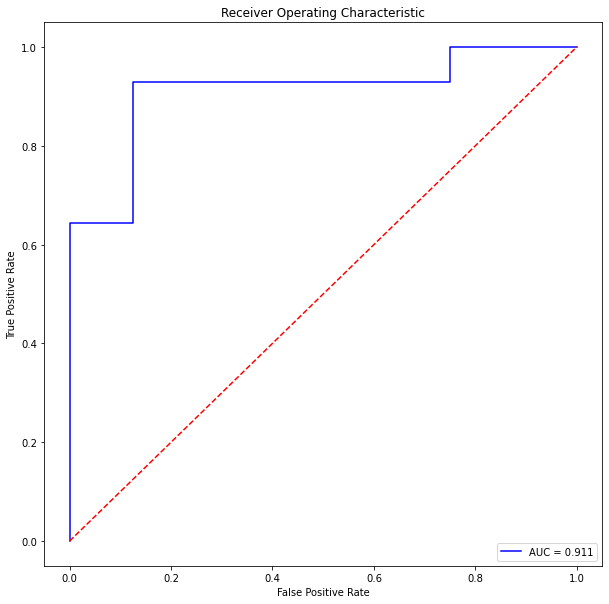

In [15]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(model_eval.sample_label,
                                         model_eval.mean_spectra_prediction)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.show()

Next, let's plot the precision-recall curve:

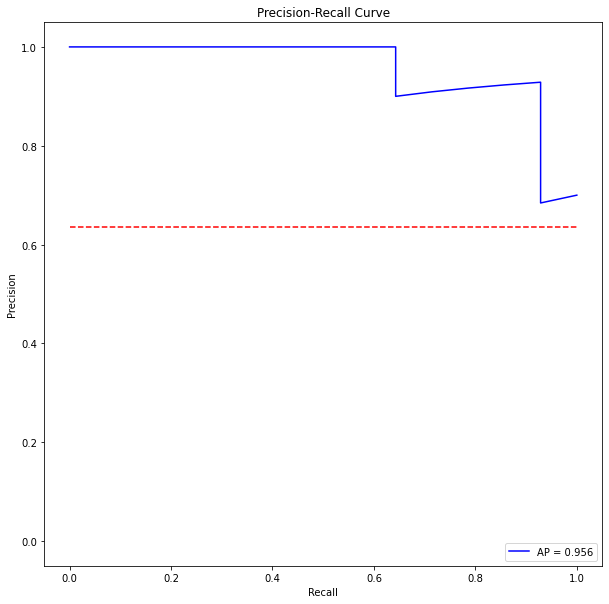

In [16]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
  model_eval.sample_label, model_eval.mean_spectra_prediction)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
  model_eval.sample_label, model_eval.mean_spectra_prediction
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(model_eval.sample_label==1) / len(model_eval.sample_label)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Precision-Recall Curve")
plt.show()

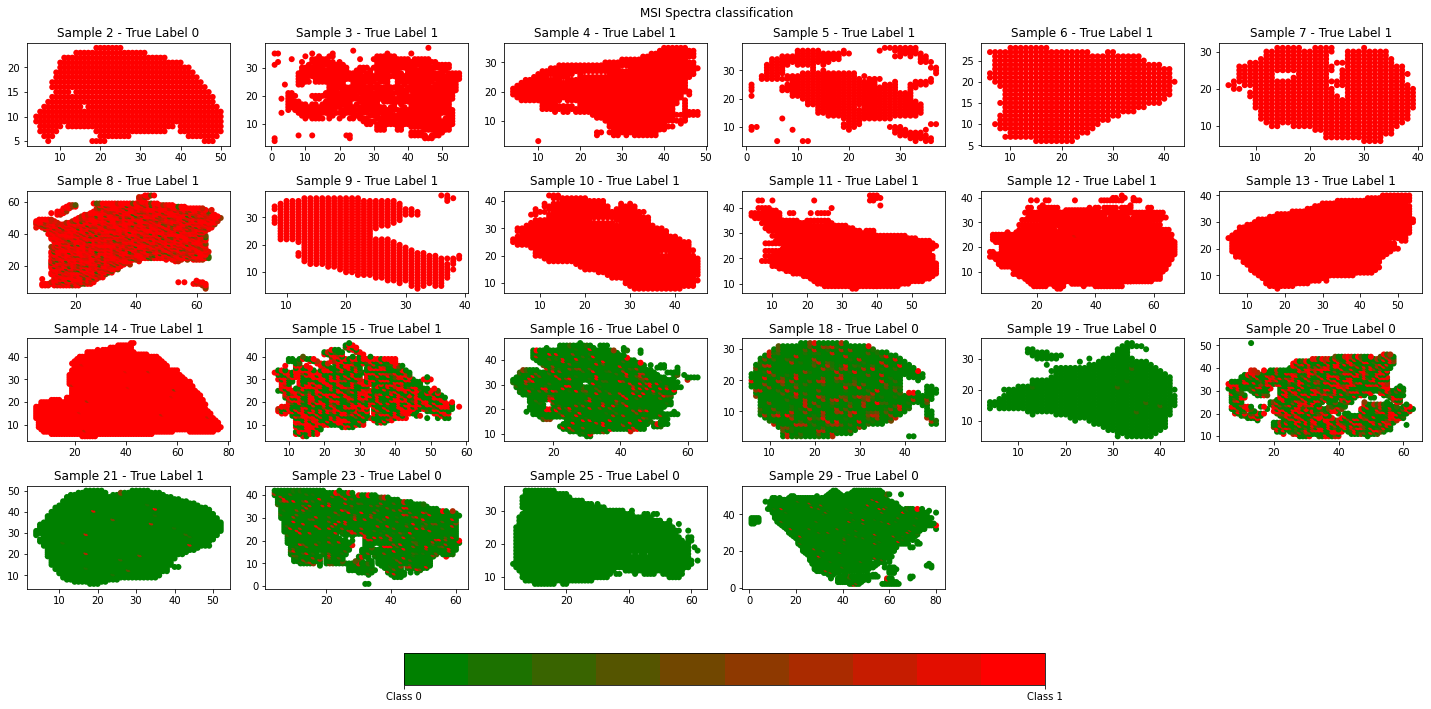

In [17]:
# Create custom binary color bar
colors = ["green", "red"]
cm = LinearSegmentedColormap.from_list("Class", colors, N=10)

# Create subplots
fig, axes = plt.subplots(4, 6, figsize=(20, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's predictions
  im = ax.scatter(x_coordinates[(sample_numbers == key) & is_tissue],
                  y_coordinates[(sample_numbers == key) & is_tissue],
                  c=predictions[key],
                  cmap=cm,
                  edgecolor=['none'],
                  vmin=0,
                  vmax=1,
                  linewidths=0)
  #
  ax.set_title(f"Sample {key} - True Label {true_labels[key][0]}")
# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("MSI Spectra classification")

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Add one color bar
cbar = fig.colorbar(im,
                    ax=axes.ravel().tolist(),
                    location="bottom",
                    orientation="horizontal",
                    fraction=0.05,
                    pad=0.10)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["Class 0", "Class 1"])

# Show plot
plt.show()

##### ***Evaluation on non tissue spectra's:***

Next, let's get the prediction of each of left out sample non tissue spectra's:

In [18]:
# Define dict for saving predictions and true labels
predictions = {}
true_labels = {}

# Loop over each sample number
for exclude_sample in tqdm(np.unique(sample_numbers)):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Create filter for training data
  test_filter = ((sample_numbers == exclude_sample) & ~is_tissue)

  # Get indexes of all data
  indexes = np.arange(len(sample_numbers))

  # Create test data generator
  test_generator = create_ds(indexes[test_filter], BATCH_SIZE, False)

  # Get saved model path
  model_path = os.path.join(
      '.', f"approach_1/excluded_{exclude_sample}/"
  )

  # Load model
  classification_model = tf.keras.models.load_model(model_path)

  # Get predictions
  predictions[exclude_sample] = classification_model.predict(x=test_generator)

  # Get corresponding true labels
  true_labels[exclude_sample] = labels[test_filter]

  # Clean model for next iteration
  classification_model = None

100%|██████████| 22/22 [02:01<00:00,  5.52s/it]


Next, let's get some statistics about each left out sample predictions:

In [19]:
# Set pandas display format
pd.options.display.float_format = '{:.10f}'.format
# Create datafrmae of each sample left out
model_eval = pd.DataFrame({"sample_left_out": predictions.keys()})
# Get the minimum prediction value of each sample left out
model_eval["min_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].min())
# Get the maximum prediction value of each sample left out
model_eval["max_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].max())
# Get the median prediction value of each sample left out
model_eval["median_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: np.median(predictions[key]))
# Get the mean prediction value of each sample left out
model_eval["mean_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].mean())
# Get the standard deviation prediction value of each sample left out
model_eval["std_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].std())
# Get the sample prediction = majority rule of sample spectra's prediction
model_eval["sample_label"] = model_eval.sample_left_out.apply(
    lambda key: true_labels[key][0])
# Get the sample true label
model_eval["sample_prediction"] = (model_eval.mean_spectra_prediction >
                                   0.5).astype(int)
# Print statistics
model_eval

,sample_left_out,min_spectra_prediction,max_spectra_prediction,median_spectra_prediction,mean_spectra_prediction,std_spectra_prediction,sample_label,sample_prediction
0,2,0.9993476272,0.9999748468,0.9999027252,0.9998876452,0.0000622350,0,1
1,3,0.9737159014,0.9999366999,0.9991520643,0.9987388253,0.0015546763,1,1
2,4,0.9999990463,1.0000000000,1.0000000000,1.0000000000,0.0000000929,1,1
3,5,0.9999954700,1.0000000000,0.9999997616,0.9999998212,0.0000004256,1,1
4,6,0.9999421835,0.9999935627,0.9999880791,0.9999858737,0.0000066961,1,1
5,7,0.9999903440,0.9999995232,0.9999989271,0.9999985695,0.0000009576,1,1
6,8,0.8924116492,0.9999935627,0.9998040795,0.9993354082,0.0024839400,1,1
7,9,0.9999184608,1.0000000000,0.9999976158,0.9999964237,0.0000043071,1,1
8,10,0.9984904528,1.0000000000,0.9999960661,0.9999858141,0.0000587212,1,1
9,11,0.8224800229,0.9999967813,0.9999693632,0.9997654557,0.0050239605,1,1


Next, let's evaluate the classification performance:

In [20]:
# Get accuracy
accuracy = metrics.accuracy_score(model_eval.sample_label,
                                  model_eval.sample_prediction)
# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(model_eval.sample_label,
                                             model_eval.sample_prediction)
# Get precision
precision = metrics.precision_score(model_eval.sample_label,
                                    model_eval.sample_prediction)
# Get recall
recall = metrics.recall_score(model_eval.sample_label,
                              model_eval.sample_prediction)
# Get  f1 score
f1 = metrics.f1_score(model_eval.sample_label, model_eval.sample_prediction)

# Print metrics
print(f"Accuracy: {accuracy:.3f}")
print(f"Balanced  Accuracy: {b_accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 score: {f1:.3f}")

Accuracy: 0.818
Balanced  Accuracy: 0.804
Precision: 0.857
Recall: 0.857
F1 score: 0.857


Next, let's plot the roc curve:

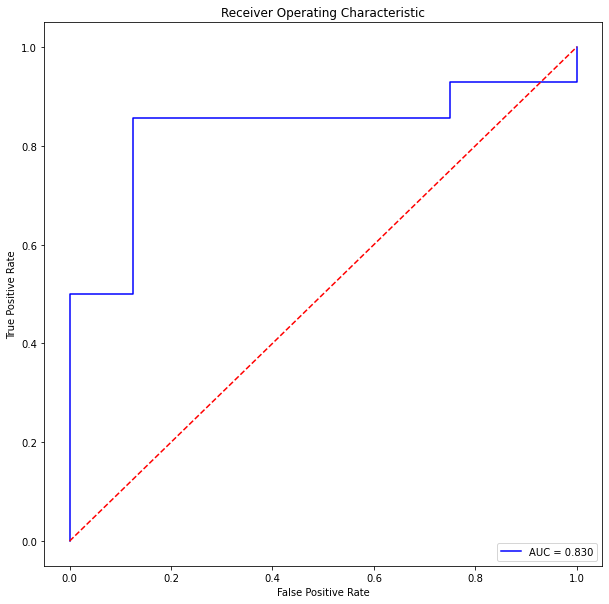

In [21]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(model_eval.sample_label,
                                         model_eval.mean_spectra_prediction)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.show()

Next, let's plot the precision-recall curve:

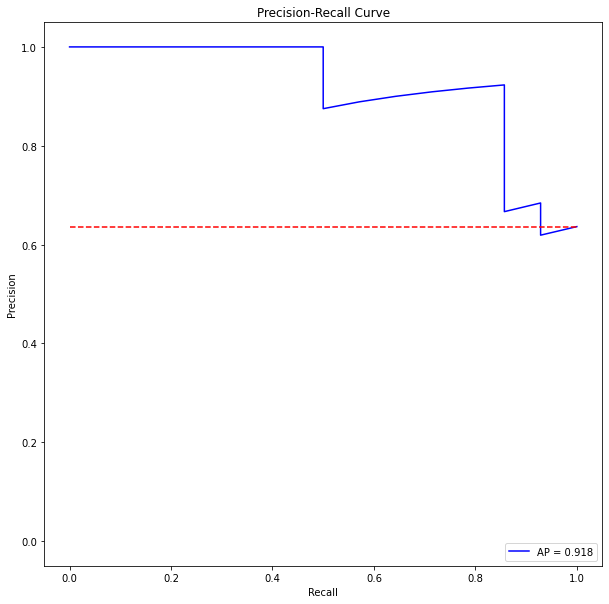

In [22]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
  model_eval.sample_label, model_eval.mean_spectra_prediction)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
  model_eval.sample_label, model_eval.mean_spectra_prediction
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(model_eval.sample_label==1) / len(model_eval.sample_label)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Precision-Recall Curve")
plt.show()

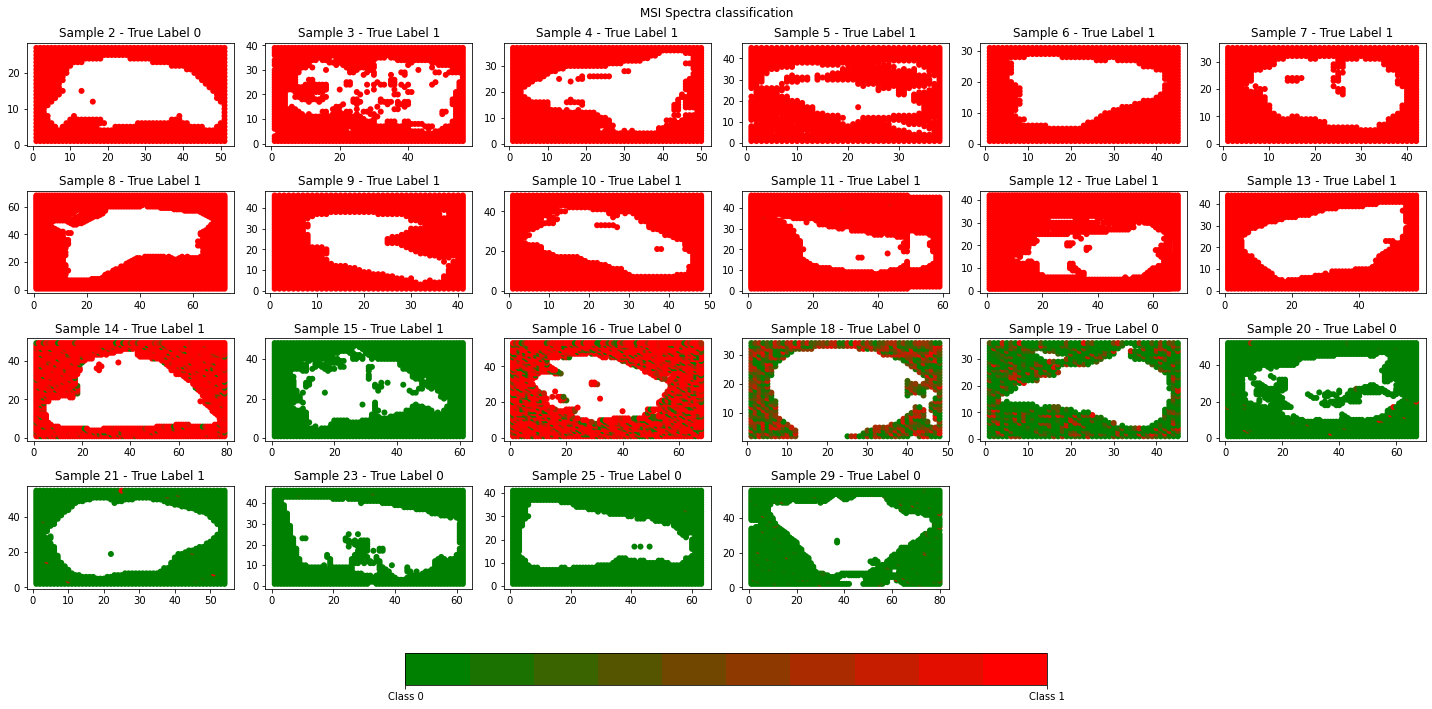

In [23]:
# Create custom binary color bar
colors = ["green", "red"]
cm = LinearSegmentedColormap.from_list("Class", colors, N=10)

# Create subplots
fig, axes = plt.subplots(4, 6, figsize=(20, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's predictions
  im = ax.scatter(x_coordinates[(sample_numbers == key) & ~is_tissue],
                  y_coordinates[(sample_numbers == key) & ~is_tissue],
                  c=predictions[key],
                  cmap=cm,
                  edgecolor=['none'],
                  vmin=0,
                  vmax=1,
                  linewidths=0)
  #
  ax.set_title(f"Sample {key} - True Label {true_labels[key][0]}")
# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("MSI Spectra classification")

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Add one color bar
cbar = fig.colorbar(im,
                    ax=axes.ravel().tolist(),
                    location="bottom",
                    orientation="horizontal",
                    fraction=0.05,
                    pad=0.10)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["Class 0", "Class 1"])

# Show plot
plt.show()

### ***Approach 2 - Leave one image out + no standardization:***

##### ***Training:***
Next, let"s create a classification model for each leave one sample out option:

In [24]:
train_metrics = {}
validation_metrics = {}

# Loop over each sample number
for exclude_image, group in tqdm(metadata_df.groupby("file_name")):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Get all spectra's in the exclude_image to exclude them 
  exclude_spectras = np.isin(sample_numbers, group.sample_number.to_list())

  # Create filter for training data - does not include the excluded image
  # and only include tissue spectra's
  train_filter = ((~exclude_spectras) & is_tissue)

  # Get indexes of all data
  indexes = np.arange(len(sample_numbers))

  # Get indexes of training data
  train_indexes = indexes[train_filter]

  # Get indexes of training and validation data
  train_indexes, val_indexes = train_test_split(
      train_indexes, test_size=0.2, random_state=0,
      stratify=labels[train_filter]
  )

  # Create data generators
  train_generator = create_ds(train_indexes, BATCH_SIZE, False)
  validation_generator = create_ds(val_indexes, BATCH_SIZE, False)

  # Create Callback to save the best model
  checkpoint_filepath = os.path.join(
      '.', f"approach_2/excluded_{exclude_image}/"
  )
  model_checkpoint_callback = callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath, save_weights_only=False,
      monitor="val_binary_accuracy", mode="max", save_best_only=True
  )

  # Create Callback for model early stopping
  model_es_callback = callbacks.EarlyStopping(
      monitor='val_loss', mode='min', verbose=1, patience=5, min_delta=0.0001
  )

  # Create classification model
  classification_model = get_model()

  # Compile the classification model
  optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
  classification_model.compile(
      optimizer, loss=losses.BinaryCrossentropy(), metrics=["binary_accuracy"]
  )

  # Train the classification model
  history = classification_model.fit(
      x=train_generator, validation_data=validation_generator, epochs=EPHOCS,
      callbacks=[model_checkpoint_callback, model_es_callback]
  )

  # Load the best saved
  classification_model = tf.keras.models.load_model(checkpoint_filepath)

  # Evaluate on train and validation
  train_metrics[exclude_image] = classification_model.evaluate(
      x=train_generator
  )
  validation_metrics[exclude_image] = classification_model.evaluate(
      x=validation_generator
  )

  # Clean model for next iteration
  classification_model = None

  # Separate training
  print("#" * 30)

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1/100
72/72 [==============================] - 29s 389ms/step - loss: 0.0856 - binary_accuracy: 0.9642 - val_loss: 0.6864 - val_binary_accuracy: 0.5665
INFO:tensorflow:Assets written to: .\approach_2/excluded_HG 11-11-12-s\assets
Epoch 2/100
72/72 [==============================] - 19s 262ms/step - loss: 0.0081 - binary_accuracy: 0.9974 - val_loss: 0.6806 - val_binary_accuracy: 0.5665
Epoch 3/100
72/72 [==============================] - 20s 271ms/step - loss: 0.0041 - binary_accuracy: 0.9988 - val_loss: 0.6542 - val_binary_accuracy: 0.5665
Epoch 4/100
72/72 [==============================] - 18s 247ms/step - loss: 0.0032 - binary_accuracy: 0.9990 - val_loss: 0.5948 - val_binary_accuracy: 0.5668
INFO:tensorflow:Assets written to: .\approach_2/excluded_HG 11-11-12-s\assets
Epoch 5/100
72/72 [==============================] - 19s 257ms/step - loss: 0.0052 - binary_accuracy: 0.9984 - val_loss: 0.4698 - val_binary_accuracy: 0.9371
INFO:tensorflow:Assets written to: .\approach_2/exclud

 12%|█▎        | 1/8 [06:14<43:42, 374.60s/it]

##############################
Epoch 1/100
76/76 [==============================] - 22s 279ms/step - loss: 0.0860 - binary_accuracy: 0.9677 - val_loss: 0.6774 - val_binary_accuracy: 0.5886
INFO:tensorflow:Assets written to: .\approach_2/excluded_HG 14-13-s\assets
Epoch 2/100
76/76 [==============================] - 20s 259ms/step - loss: 0.0067 - binary_accuracy: 0.9980 - val_loss: 0.6779 - val_binary_accuracy: 0.5886
Epoch 3/100
76/76 [==============================] - 20s 258ms/step - loss: 0.0025 - binary_accuracy: 0.9993 - val_loss: 0.6555 - val_binary_accuracy: 0.5886
Epoch 4/100
76/76 [==============================] - 19s 246ms/step - loss: 0.0025 - binary_accuracy: 0.9993 - val_loss: 0.6049 - val_binary_accuracy: 0.5886
Epoch 5/100
76/76 [==============================] - 19s 246ms/step - loss: 0.0010 - binary_accuracy: 0.9996 - val_loss: 0.4463 - val_binary_accuracy: 0.6695
INFO:tensorflow:Assets written to: .\approach_2/excluded_HG 14-13-s\assets
Epoch 6/100
76/76 [==========

 25%|██▌       | 2/8 [13:34<41:16, 412.80s/it]

##############################
Epoch 1/100
78/78 [==============================] - 21s 257ms/step - loss: 0.0732 - binary_accuracy: 0.9711 - val_loss: 0.6468 - val_binary_accuracy: 0.6520
INFO:tensorflow:Assets written to: .\approach_2/excluded_HG 16-15-s\assets
Epoch 2/100
78/78 [==============================] - 21s 263ms/step - loss: 0.0049 - binary_accuracy: 0.9983 - val_loss: 0.6516 - val_binary_accuracy: 0.6520
Epoch 3/100
78/78 [==============================] - 20s 257ms/step - loss: 0.0014 - binary_accuracy: 0.9998 - val_loss: 0.6525 - val_binary_accuracy: 0.9293
INFO:tensorflow:Assets written to: .\approach_2/excluded_HG 16-15-s\assets
Epoch 4/100
78/78 [==============================] - 20s 258ms/step - loss: 8.5539e-04 - binary_accuracy: 0.9998 - val_loss: 0.6067 - val_binary_accuracy: 0.9638
INFO:tensorflow:Assets written to: .\approach_2/excluded_HG 16-15-s\assets
Epoch 5/100
78/78 [==============================] - 20s 260ms/step - loss: 6.4112e-04 - binary_accuracy: 0.

 38%|███▊      | 3/8 [19:25<32:04, 384.85s/it]

##############################
Epoch 1/100
81/81 [==============================] - 21s 253ms/step - loss: 0.0758 - binary_accuracy: 0.9745 - val_loss: 0.6330 - val_binary_accuracy: 0.6762
INFO:tensorflow:Assets written to: .\approach_2/excluded_HG 19-18-s\assets
Epoch 2/100
81/81 [==============================] - 22s 270ms/step - loss: 0.0091 - binary_accuracy: 0.9970 - val_loss: 0.6278 - val_binary_accuracy: 0.6762
Epoch 3/100
81/81 [==============================] - 20s 251ms/step - loss: 0.0035 - binary_accuracy: 0.9988 - val_loss: 0.6237 - val_binary_accuracy: 0.6762
Epoch 4/100
81/81 [==============================] - 21s 257ms/step - loss: 0.0022 - binary_accuracy: 0.9993 - val_loss: 0.5701 - val_binary_accuracy: 0.6762
Epoch 5/100
81/81 [==============================] - 21s 265ms/step - loss: 0.0011 - binary_accuracy: 0.9997 - val_loss: 0.3486 - val_binary_accuracy: 0.8288
INFO:tensorflow:Assets written to: .\approach_2/excluded_HG 19-18-s\assets
Epoch 6/100
81/81 [==========

 50%|█████     | 4/8 [25:04<24:25, 366.48s/it]

##############################
Epoch 1/100
61/61 [==============================] - 16s 248ms/step - loss: 0.1271 - binary_accuracy: 0.9537 - val_loss: 0.5241 - val_binary_accuracy: 0.8139
INFO:tensorflow:Assets written to: .\approach_2/excluded_HG 29-25-23-21-20-s\assets
Epoch 2/100
61/61 [==============================] - 15s 253ms/step - loss: 0.0039 - binary_accuracy: 0.9994 - val_loss: 0.5252 - val_binary_accuracy: 0.8139
Epoch 3/100
61/61 [==============================] - 16s 257ms/step - loss: 0.0019 - binary_accuracy: 0.9997 - val_loss: 0.5702 - val_binary_accuracy: 0.8139
Epoch 4/100
61/61 [==============================] - 14s 233ms/step - loss: 7.7603e-04 - binary_accuracy: 1.0000 - val_loss: 0.6273 - val_binary_accuracy: 0.8139
Epoch 5/100
61/61 [==============================] - 15s 245ms/step - loss: 0.0011 - binary_accuracy: 0.9999 - val_loss: 0.6555 - val_binary_accuracy: 0.9564
INFO:tensorflow:Assets written to: .\approach_2/excluded_HG 29-25-23-21-20-s\assets
Epoch 6

 62%|██████▎   | 5/8 [27:03<13:52, 277.39s/it]

##############################
Epoch 1/100
82/82 [==============================] - 22s 259ms/step - loss: 0.0751 - binary_accuracy: 0.9706 - val_loss: 0.6727 - val_binary_accuracy: 0.6185
INFO:tensorflow:Assets written to: .\approach_2/excluded_HG 6-7-s\assets
Epoch 2/100
82/82 [==============================] - 22s 265ms/step - loss: 0.0073 - binary_accuracy: 0.9977 - val_loss: 0.6860 - val_binary_accuracy: 0.6185
Epoch 3/100
82/82 [==============================] - 22s 267ms/step - loss: 0.0043 - binary_accuracy: 0.9986 - val_loss: 0.6264 - val_binary_accuracy: 0.6185
Epoch 4/100
82/82 [==============================] - 21s 253ms/step - loss: 0.0031 - binary_accuracy: 0.9988 - val_loss: 0.5528 - val_binary_accuracy: 0.6188
INFO:tensorflow:Assets written to: .\approach_2/excluded_HG 6-7-s\assets
Epoch 5/100
82/82 [==============================] - 20s 247ms/step - loss: 0.0023 - binary_accuracy: 0.9992 - val_loss: 0.3675 - val_binary_accuracy: 0.8247
INFO:tensorflow:Assets written to

 75%|███████▌  | 6/8 [35:30<11:51, 355.51s/it]

##############################
Epoch 1/100
62/62 [==============================] - 17s 260ms/step - loss: 0.1378 - binary_accuracy: 0.9577 - val_loss: 0.6842 - val_binary_accuracy: 0.5269
INFO:tensorflow:Assets written to: .\approach_2/excluded_HG 8-12-5-4-3-2-s\assets
Epoch 2/100
62/62 [==============================] - 16s 250ms/step - loss: 0.0081 - binary_accuracy: 0.9973 - val_loss: 0.6762 - val_binary_accuracy: 0.6159
INFO:tensorflow:Assets written to: .\approach_2/excluded_HG 8-12-5-4-3-2-s\assets
Epoch 3/100
62/62 [==============================] - 15s 239ms/step - loss: 0.0025 - binary_accuracy: 0.9992 - val_loss: 0.6497 - val_binary_accuracy: 0.9923
INFO:tensorflow:Assets written to: .\approach_2/excluded_HG 8-12-5-4-3-2-s\assets
Epoch 4/100
62/62 [==============================] - 16s 253ms/step - loss: 0.0018 - binary_accuracy: 0.9993 - val_loss: 0.6064 - val_binary_accuracy: 0.6771
Epoch 5/100
62/62 [==============================] - 14s 227ms/step - loss: 0.0015 - binary

 88%|████████▊ | 7/8 [42:47<06:22, 382.20s/it]

##############################
Epoch 1/100
81/81 [==============================] - 21s 249ms/step - loss: 0.0699 - binary_accuracy: 0.9731 - val_loss: 0.6709 - val_binary_accuracy: 0.6144
INFO:tensorflow:Assets written to: .\approach_2/excluded_HG 9-10-s\assets
Epoch 2/100
81/81 [==============================] - 22s 268ms/step - loss: 0.0086 - binary_accuracy: 0.9971 - val_loss: 0.6630 - val_binary_accuracy: 0.6144
Epoch 3/100
81/81 [==============================] - 21s 259ms/step - loss: 0.0045 - binary_accuracy: 0.9988 - val_loss: 0.6314 - val_binary_accuracy: 0.6144
Epoch 4/100
81/81 [==============================] - 21s 258ms/step - loss: 0.0022 - binary_accuracy: 0.9993 - val_loss: 0.5384 - val_binary_accuracy: 0.6181
INFO:tensorflow:Assets written to: .\approach_2/excluded_HG 9-10-s\assets
Epoch 5/100
81/81 [==============================] - 21s 262ms/step - loss: 0.0013 - binary_accuracy: 0.9998 - val_loss: 0.3916 - val_binary_accuracy: 0.7171
INFO:tensorflow:Assets written 

100%|██████████| 8/8 [49:51<00:00, 373.88s/it]

##############################


In [25]:
train_metrics

{'HG 11-11-12-s': [1.3356659110286273e-05, 1.0],
 'HG 14-13-s': [1.9291775970486924e-05, 1.0],
 'HG 16-15-s': [0.05783228203654289, 1.0],
 'HG 19-18-s': [0.0002789594291243702, 1.0],
 'HG 29-25-23-21-20-s': [0.6546845436096191, 0.9578709602355957],
 'HG 6-7-s': [5.308994332153816e-06, 1.0],
 'HG 8-12-5-4-3-2-s': [1.481316530771437e-06, 1.0],
 'HG 9-10-s': [2.1484891021827934e-06, 1.0]}

In [26]:
validation_metrics

{'HG 11-11-12-s': [0.0010586727876216173, 0.9995643496513367],
 'HG 14-13-s': [0.0008835380431264639, 0.9997931718826294],
 'HG 16-15-s': [0.06165516376495361, 1.0],
 'HG 19-18-s': [0.004307472612708807, 0.9988310933113098],
 'HG 29-25-23-21-20-s': [0.6554751992225647, 0.9563871026039124],
 'HG 6-7-s': [0.0006265019183047116, 0.9998081922531128],
 'HG 8-12-5-4-3-2-s': [0.0033060989808291197, 0.9994899034500122],
 'HG 9-10-s': [0.002328272443264723, 0.9996122717857361]}

##### ***Evaluation on tissue spectra's:***

Next, let's get the prediction of each of left out sample spectra's:

In [27]:
# Define dict for saving predictions and true labels
predictions = {}
true_labels = {}

# Loop over each sample number
for index, row in tqdm(metadata_df.iterrows(), total=metadata_df.shape[0],
                           desc="MSI Loop"):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Create filter for training data
  test_filter = ((file_names == row.sample_file_name) & is_tissue)

  # Get indexes of all data
  indexes = np.arange(len(sample_numbers))

  # Create test data generator
  test_generator = create_ds(indexes[test_filter], BATCH_SIZE, False)

  # Get saved model path
  model_path = os.path.join(
      '.', f"approach_2/excluded_{row.file_name}/"
  )

  # Load model
  classification_model = tf.keras.models.load_model(model_path)

  # Get predictions
  predictions[row.sample_file_name] = classification_model.predict(x=test_generator)

  # Get corresponding true labels
  true_labels[row.sample_file_name] = labels[test_filter]

  # Clean model for next iteration
  classification_model = None

MSI Loop: 100%|██████████| 24/24 [01:36<00:00,  4.04s/it]


Next, let's get some statistics about each left out sample predictions:

In [28]:
# Set pandas display format
pd.options.display.float_format = '{:.10f}'.format
# Create datafrmae of each sample left out
model_eval = pd.DataFrame({"sample_left_out": predictions.keys()})
# Get the minimum prediction value of each sample left out
model_eval["min_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].min())
# Get the maximum prediction value of each sample left out
model_eval["max_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].max())
# Get the median prediction value of each sample left out
model_eval["median_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: np.median(predictions[key]))
# Get the mean prediction value of each sample left out
model_eval["mean_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].mean())
# Get the standard deviation prediction value of each sample left out
model_eval["std_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].std())
# Get the sample prediction = majority rule of sample spectra's prediction
model_eval["sample_label"] = model_eval.sample_left_out.apply(
    lambda key: true_labels[key][0])
# Get the sample true label
model_eval["sample_prediction"] = (model_eval.mean_spectra_prediction >
                                   0.5).astype(int)
# Print statistics
model_eval

,sample_left_out,min_spectra_prediction,max_spectra_prediction,median_spectra_prediction,mean_spectra_prediction,std_spectra_prediction,sample_label,sample_prediction
0,HG 11_1-s,0.9832732677,1.0000000000,0.9999936819,0.9996873140,0.0011432300,1,1
1,HG 11_2-s,0.9909074306,1.0000000000,0.9999905825,0.9997494221,0.0008004803,1,1
2,HG 12-s,0.9813073874,1.0000000000,0.9999985695,0.9995111227,0.0016119375,1,1
3,HG 14-s,0.0000000112,0.9985777140,0.0055073202,0.1642169952,0.2987194955,1,0
4,HG 13-s,0.0000000027,0.9994698167,0.7855840325,0.6198732257,0.3691863120,1,1
5,HG 15-s,0.0013925497,0.9588727355,0.2626494765,0.3580895662,0.3251309991,1,0
6,HG 16-s,0.0009717737,0.2981556058,0.0089838486,0.0149931964,0.0241640229,0,0
7,HG 19-s,0.9989033937,0.9998186231,0.9993366599,0.9993390441,0.0001418784,0,1
8,HG 18-s,0.9981191754,0.9997838140,0.9993177652,0.9992914200,0.0001672542,0,1
9,HG 29-s,0.4829099774,0.5286331177,0.5119228959,0.5125834942,0.0052363793,0,1


Next, let's evaluate the classification performance:

In [29]:
# Get accuracy
accuracy = metrics.accuracy_score(model_eval.sample_label,
                                  model_eval.sample_prediction)
# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(model_eval.sample_label,
                                             model_eval.sample_prediction)
# Get precision
precision = metrics.precision_score(model_eval.sample_label,
                                    model_eval.sample_prediction)
# Get recall
recall = metrics.recall_score(model_eval.sample_label,
                              model_eval.sample_prediction)
# Get  f1 score
f1 = metrics.f1_score(model_eval.sample_label, model_eval.sample_prediction)

# Print metrics
print(f"Accuracy: {accuracy:.3f}")
print(f"Balanced  Accuracy: {b_accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 score: {f1:.3f}")

Accuracy: 0.333
Balanced  Accuracy: 0.312
Precision: 0.500
Recall: 0.375
F1 score: 0.429


Next, let's plot the roc curve:

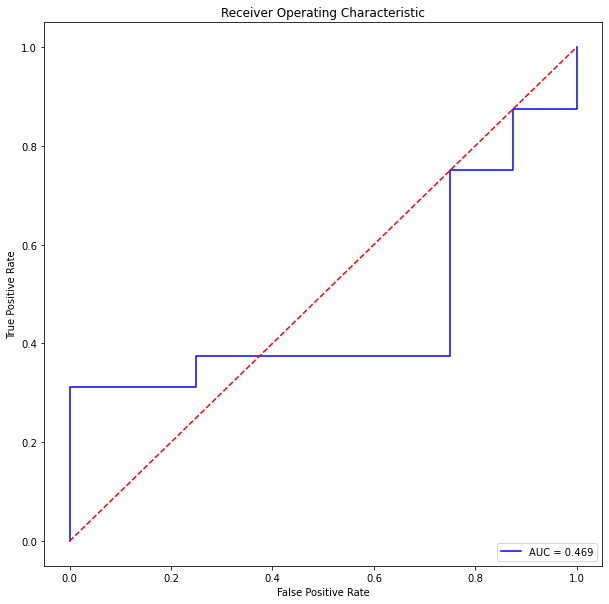

In [30]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(model_eval.sample_label,
                                         model_eval.mean_spectra_prediction)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.show()

Next, let's plot the precision-recall curve:

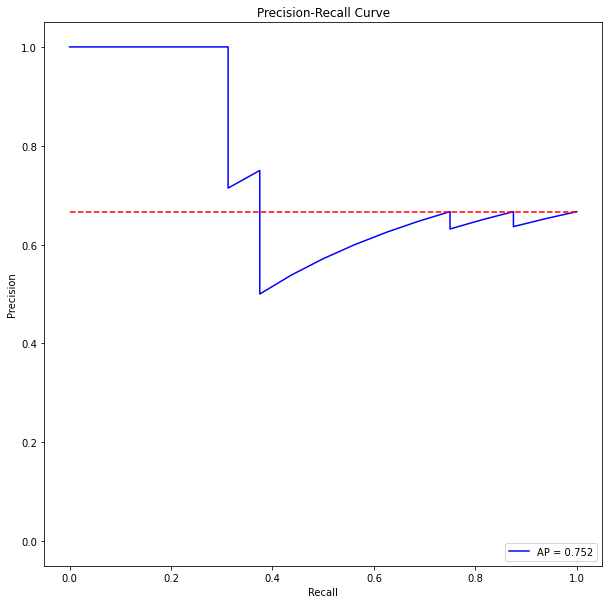

In [31]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
  model_eval.sample_label, model_eval.mean_spectra_prediction)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
  model_eval.sample_label, model_eval.mean_spectra_prediction
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(model_eval.sample_label==1) / len(model_eval.sample_label)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Precision-Recall Curve")
plt.show()

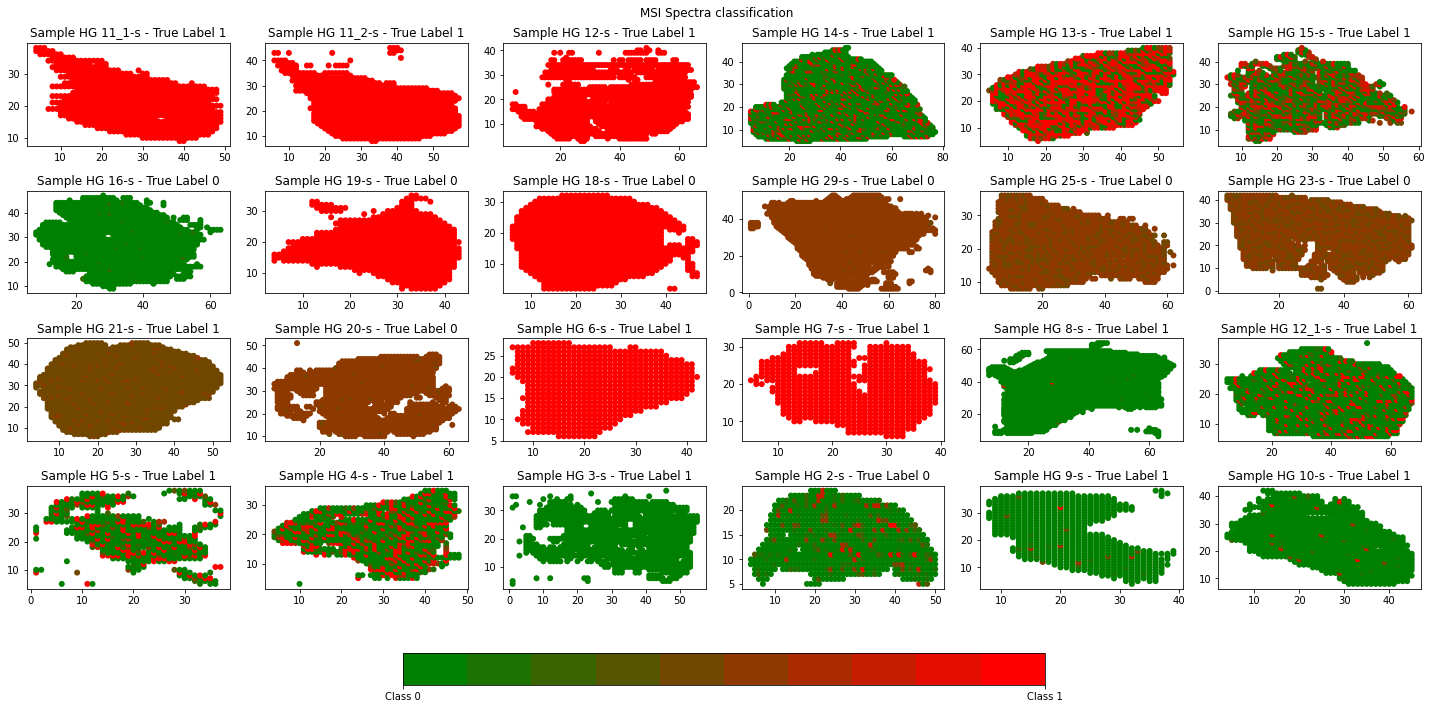

In [32]:
# Create custom binary color bar
colors = ["green", "red"]
cm = LinearSegmentedColormap.from_list("Class", colors, N=10)

# Create subplots
fig, axes = plt.subplots(4, 6, figsize=(20, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's predictions
  im = ax.scatter(x_coordinates[(file_names == key) & is_tissue],
                  y_coordinates[(file_names == key) & is_tissue],
                  c=predictions[key],
                  cmap=cm,
                  edgecolor=['none'],
                  vmin=0,
                  vmax=1,
                  linewidths=0)
  #
  ax.set_title(f"Sample {key} - True Label {true_labels[key][0]}")
# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("MSI Spectra classification")

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Add one color bar
cbar = fig.colorbar(im,
                    ax=axes.ravel().tolist(),
                    location="bottom",
                    orientation="horizontal",
                    fraction=0.05,
                    pad=0.10)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["Class 0", "Class 1"])

# Show plot
plt.show()

##### ***Evaluation on non tissue spectra's:***

Next, let's get the prediction of each of left out sample non tissue spectra's:

In [33]:
# Define dict for saving predictions and true labels
predictions = {}
true_labels = {}

# Loop over each sample number
for index, row in tqdm(metadata_df.iterrows(), total=metadata_df.shape[0],
                           desc="MSI Loop"):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Create filter for training data
  test_filter = ((file_names == row.sample_file_name) & ~is_tissue)

  # Get indexes of all data
  indexes = np.arange(len(sample_numbers))

  # Create test data generator
  test_generator = create_ds(indexes[test_filter], BATCH_SIZE, False)

  # Get saved model path
  model_path = os.path.join(
      '.', f"approach_2/excluded_{row.file_name}/"
  )

  # Load model
  classification_model = tf.keras.models.load_model(model_path)

  # Get predictions
  predictions[row.sample_file_name] = classification_model.predict(x=test_generator)

  # Get corresponding true labels
  true_labels[row.sample_file_name] = labels[test_filter]

  # Clean model for next iteration
  classification_model = None

MSI Loop: 100%|██████████| 24/24 [01:57<00:00,  4.90s/it]


Next, let's get some statistics about each left out sample predictions:

In [34]:
# Set pandas display format
pd.options.display.float_format = '{:.10f}'.format
# Create datafrmae of each sample left out
model_eval = pd.DataFrame({"sample_left_out": predictions.keys()})
# Get the minimum prediction value of each sample left out
model_eval["min_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].min())
# Get the maximum prediction value of each sample left out
model_eval["max_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].max())
# Get the median prediction value of each sample left out
model_eval["median_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: np.median(predictions[key]))
# Get the mean prediction value of each sample left out
model_eval["mean_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].mean())
# Get the standard deviation prediction value of each sample left out
model_eval["std_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].std())
# Get the sample prediction = majority rule of sample spectra's prediction
model_eval["sample_label"] = model_eval.sample_left_out.apply(
    lambda key: true_labels[key][0])
# Get the sample true label
model_eval["sample_prediction"] = (model_eval.mean_spectra_prediction >
                                   0.5).astype(int)
# Print statistics
model_eval

,sample_left_out,min_spectra_prediction,max_spectra_prediction,median_spectra_prediction,mean_spectra_prediction,std_spectra_prediction,sample_label,sample_prediction
0,HG 11_1-s,0.5560910106,0.9999954700,0.9997393489,0.9989457726,0.0129411919,1,1
1,HG 11_2-s,0.6489028931,0.9999963045,0.9998941422,0.9993113279,0.0101568401,1,1
2,HG 12-s,0.9850727916,0.9999998808,0.9998663664,0.9994108081,0.0011894624,1,1
3,HG 14-s,0.0000000012,0.9647002816,0.0000039128,0.0110109271,0.0680308565,1,0
4,HG 13-s,0.0000000006,0.5165932178,0.0000062457,0.0019195952,0.0186050814,1,0
5,HG 15-s,0.0022211242,0.2319693118,0.0254190248,0.0308160391,0.0204626340,1,0
6,HG 16-s,0.0033228116,0.2749224901,0.0360231064,0.0440007336,0.0320990011,0,0
7,HG 19-s,0.9991287589,0.9999645948,0.9999219179,0.9998881817,0.0000934222,0,1
8,HG 18-s,0.9991111159,0.9999606609,0.9998972416,0.9998412728,0.0001448485,0,1
9,HG 29-s,0.5171488523,0.5344548225,0.5268054008,0.5268467069,0.0020339163,0,1


Next, let's evaluate the classification performance:

In [35]:
# Get accuracy
accuracy = metrics.accuracy_score(model_eval.sample_label,
                                  model_eval.sample_prediction)
# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(model_eval.sample_label,
                                             model_eval.sample_prediction)
# Get precision
precision = metrics.precision_score(model_eval.sample_label,
                                    model_eval.sample_prediction)
# Get recall
recall = metrics.recall_score(model_eval.sample_label,
                              model_eval.sample_prediction)
# Get  f1 score
f1 = metrics.f1_score(model_eval.sample_label, model_eval.sample_prediction)

# Print metrics
print(f"Accuracy: {accuracy:.3f}")
print(f"Balanced  Accuracy: {b_accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 score: {f1:.3f}")

Accuracy: 0.333
Balanced  Accuracy: 0.312
Precision: 0.500
Recall: 0.375
F1 score: 0.429


Next, let's plot the roc curve:

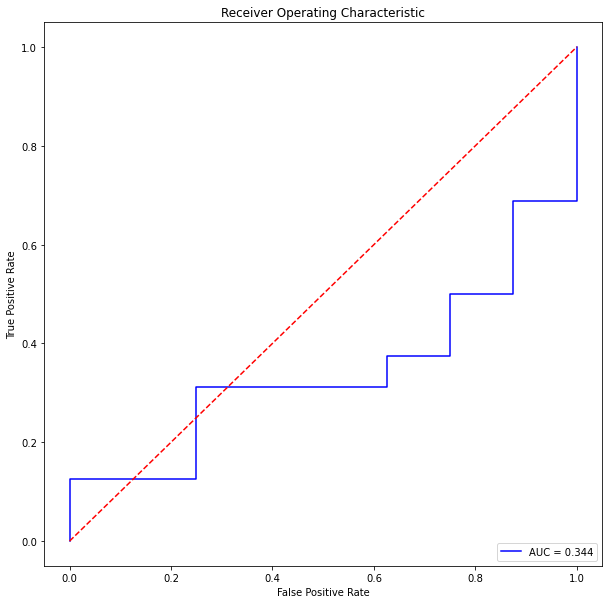

In [36]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(model_eval.sample_label,
                                         model_eval.mean_spectra_prediction)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.show()

Next, let's plot the precision-recall curve:

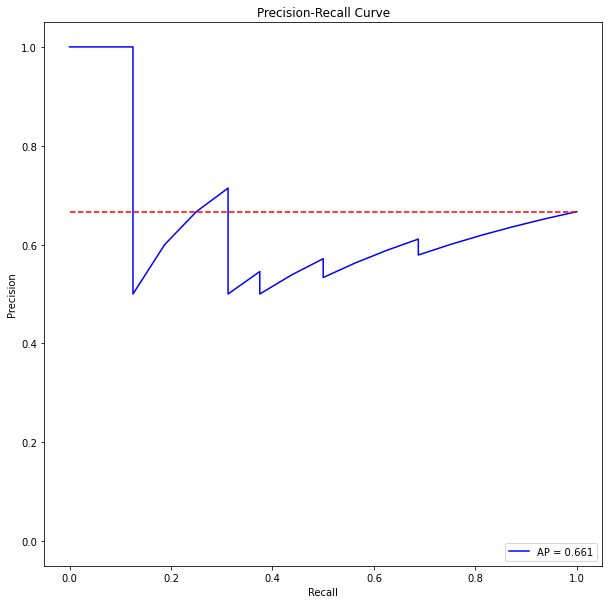

In [37]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
  model_eval.sample_label, model_eval.mean_spectra_prediction)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
  model_eval.sample_label, model_eval.mean_spectra_prediction
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(model_eval.sample_label==1) / len(model_eval.sample_label)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Precision-Recall Curve")
plt.show()

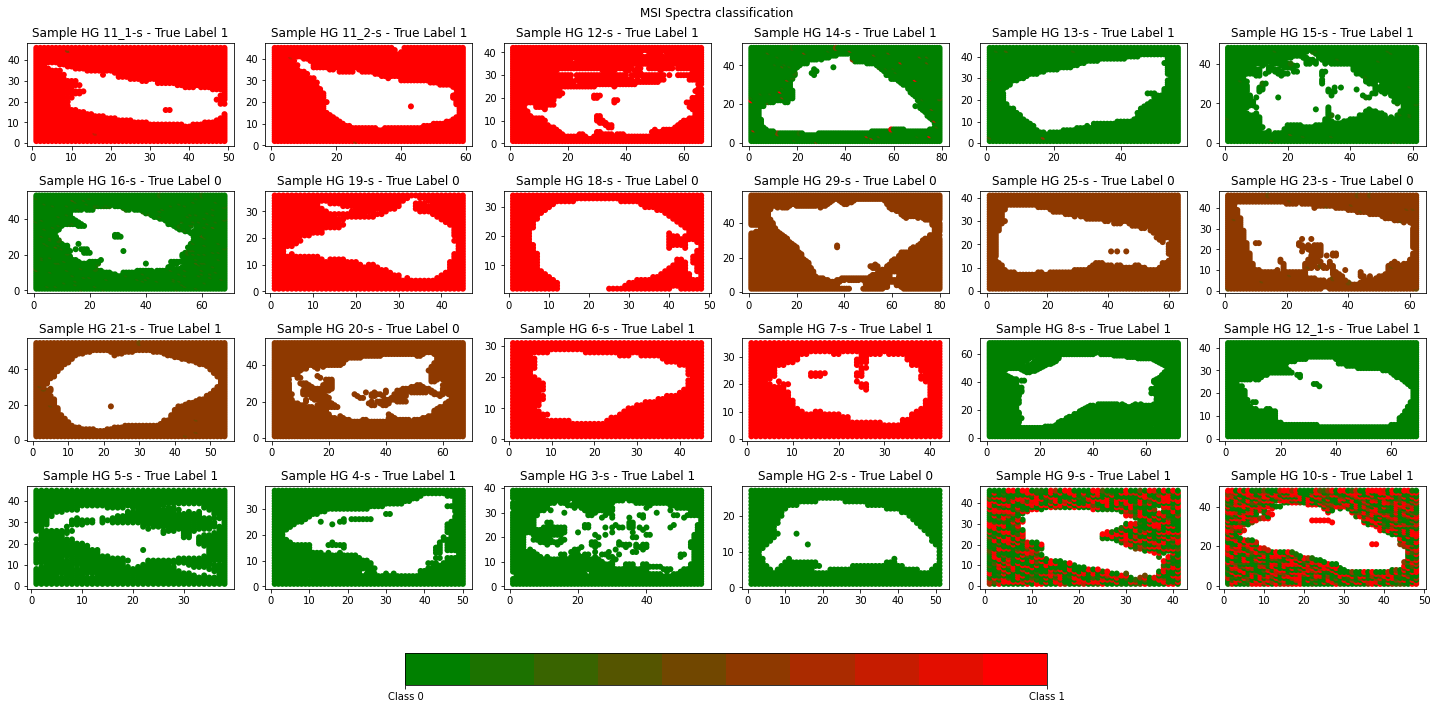

In [38]:
# Create custom binary color bar
colors = ["green", "red"]
cm = LinearSegmentedColormap.from_list("Class", colors, N=10)

# Create subplots
fig, axes = plt.subplots(4, 6, figsize=(20, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's predictions
  im = ax.scatter(x_coordinates[(file_names == key) & ~is_tissue],
                  y_coordinates[(file_names == key) & ~is_tissue],
                  c=predictions[key],
                  cmap=cm,
                  edgecolor=['none'],
                  vmin=0,
                  vmax=1,
                  linewidths=0)
  #
  ax.set_title(f"Sample {key} - True Label {true_labels[key][0]}")
# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("MSI Spectra classification")

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Add one color bar
cbar = fig.colorbar(im,
                    ax=axes.ravel().tolist(),
                    location="bottom",
                    orientation="horizontal",
                    fraction=0.05,
                    pad=0.10)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["Class 0", "Class 1"])

# Show plot
plt.show()

### ***Approach 3 - Leave one image out + standardization:***

##### ***Training:***
Next, let"s create a classification model for each leave one sample out option:

In [39]:
train_metrics = {}
validation_metrics = {}

# Loop over each sample number
for exclude_image, group in tqdm(metadata_df.groupby("file_name")):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Get all spectra's in the exclude_image to exclude them 
  exclude_spectras = np.isin(sample_numbers, group.sample_number.to_list())

  # Create filter for training data - does not include the excluded image
  # and only include tissue spectra's
  train_filter = ((~exclude_spectras) & is_tissue)

  # Get indexes of all data
  indexes = np.arange(len(sample_numbers))

  # Get indexes of training data
  train_indexes = indexes[train_filter]

  # Get indexes of training and validation data
  train_indexes, val_indexes = train_test_split(
      train_indexes, test_size=0.2, random_state=0,
      stratify=labels[train_filter]
  )

  # Create data generators
  train_generator = create_ds(train_indexes, BATCH_SIZE, True)
  validation_generator = create_ds(val_indexes, BATCH_SIZE, True)

  # Create Callback to save the best model
  checkpoint_filepath = os.path.join(
      '.', f"approach_3/excluded_{exclude_image}/"
  )
  model_checkpoint_callback = callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath, save_weights_only=False,
      monitor="val_binary_accuracy", mode="max", save_best_only=True
  )

  # Create Callback for model early stopping
  model_es_callback = callbacks.EarlyStopping(
      monitor='val_loss', mode='min', verbose=1, patience=5, min_delta=0.0001
  )

  # Create classification model
  classification_model = get_model()

  # Compile the classification model
  optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
  classification_model.compile(
      optimizer, loss=losses.BinaryCrossentropy(), metrics=["binary_accuracy"]
  )

  # Train the classification model
  history = classification_model.fit(
      x=train_generator, validation_data=validation_generator, epochs=EPHOCS,
      callbacks=[model_checkpoint_callback, model_es_callback]
  )

  # Load the best saved
  classification_model = tf.keras.models.load_model(checkpoint_filepath)

  # Evaluate on train and validation
  train_metrics[exclude_image] = classification_model.evaluate(
      x=train_generator
  )
  validation_metrics[exclude_image] = classification_model.evaluate(
      x=validation_generator
  )

  # Clean model for next iteration
  classification_model = None

  # Separate training
  print("#" * 30)

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1/100
72/72 [==============================] - 34s 464ms/step - loss: 0.0918 - binary_accuracy: 0.9667 - val_loss: 0.0917 - val_binary_accuracy: 0.9680
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 11-11-12-s\assets
Epoch 2/100
72/72 [==============================] - 24s 339ms/step - loss: 0.0123 - binary_accuracy: 0.9958 - val_loss: 0.0102 - val_binary_accuracy: 0.9974
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 11-11-12-s\assets
Epoch 3/100
72/72 [==============================] - 26s 362ms/step - loss: 0.0091 - binary_accuracy: 0.9974 - val_loss: 0.0469 - val_binary_accuracy: 0.9878
Epoch 4/100
72/72 [==============================] - 25s 351ms/step - loss: 0.0054 - binary_accuracy: 0.9984 - val_loss: 0.0197 - val_binary_accuracy: 0.9948
Epoch 5/100
72/72 [==============================] - 24s 335ms/step - loss: 0.0032 - binary_accuracy: 0.9992 - val_loss: 0.0179 - val_binary_accuracy: 0.9946
Epoch 6/100
72/72 [==============================] - 2

 12%|█▎        | 1/8 [03:41<25:49, 221.41s/it]

##############################
Epoch 1/100
76/76 [==============================] - 28s 353ms/step - loss: 0.0829 - binary_accuracy: 0.9681 - val_loss: 0.1696 - val_binary_accuracy: 0.9613
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 14-13-s\assets
Epoch 2/100
76/76 [==============================] - 26s 347ms/step - loss: 0.0109 - binary_accuracy: 0.9966 - val_loss: 0.0159 - val_binary_accuracy: 0.9961
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 14-13-s\assets
Epoch 3/100
76/76 [==============================] - 26s 338ms/step - loss: 0.0059 - binary_accuracy: 0.9981 - val_loss: 0.0189 - val_binary_accuracy: 0.9952
Epoch 4/100
76/76 [==============================] - 25s 331ms/step - loss: 0.0038 - binary_accuracy: 0.9988 - val_loss: 0.0481 - val_binary_accuracy: 0.9888
Epoch 5/100
76/76 [==============================] - 26s 338ms/step - loss: 0.0029 - binary_accuracy: 0.9990 - val_loss: 0.0240 - val_binary_accuracy: 0.9938
Epoch 6/100
76/76 [==========

 25%|██▌       | 2/8 [07:24<22:12, 222.11s/it]

##############################
Epoch 1/100
78/78 [==============================] - 27s 336ms/step - loss: 0.0710 - binary_accuracy: 0.9752 - val_loss: 0.0083 - val_binary_accuracy: 0.9976
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 16-15-s\assets
Epoch 2/100
78/78 [==============================] - 27s 348ms/step - loss: 0.0088 - binary_accuracy: 0.9978 - val_loss: 0.0080 - val_binary_accuracy: 0.9972
Epoch 3/100
78/78 [==============================] - 27s 342ms/step - loss: 0.0039 - binary_accuracy: 0.9989 - val_loss: 0.0222 - val_binary_accuracy: 0.9936
Epoch 4/100
78/78 [==============================] - 27s 351ms/step - loss: 0.0060 - binary_accuracy: 0.9986 - val_loss: 0.0132 - val_binary_accuracy: 0.9960
Epoch 5/100
78/78 [==============================] - 28s 361ms/step - loss: 0.0040 - binary_accuracy: 0.9990 - val_loss: 0.0147 - val_binary_accuracy: 0.9950
Epoch 6/100
78/78 [==============================] - 27s 350ms/step - loss: 0.0024 - binary_accuracy: 0.

 38%|███▊      | 3/8 [11:11<18:43, 224.66s/it]

##############################
Epoch 1/100
81/81 [==============================] - 28s 336ms/step - loss: 0.0755 - binary_accuracy: 0.9726 - val_loss: 0.0507 - val_binary_accuracy: 0.9862
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 19-18-s\assets
Epoch 2/100
81/81 [==============================] - 27s 335ms/step - loss: 0.0079 - binary_accuracy: 0.9979 - val_loss: 0.0124 - val_binary_accuracy: 0.9961
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 19-18-s\assets
Epoch 3/100
81/81 [==============================] - 27s 328ms/step - loss: 0.0113 - binary_accuracy: 0.9974 - val_loss: 0.0289 - val_binary_accuracy: 0.9918
Epoch 4/100
81/81 [==============================] - 28s 350ms/step - loss: 0.0037 - binary_accuracy: 0.9988 - val_loss: 0.0281 - val_binary_accuracy: 0.9918
Epoch 5/100
81/81 [==============================] - 26s 326ms/step - loss: 0.0029 - binary_accuracy: 0.9989 - val_loss: 0.0157 - val_binary_accuracy: 0.9953
Epoch 6/100
81/81 [==========

 50%|█████     | 4/8 [15:04<15:11, 227.76s/it]

##############################
Epoch 1/100
61/61 [==============================] - 22s 341ms/step - loss: 0.1017 - binary_accuracy: 0.9592 - val_loss: 0.1843 - val_binary_accuracy: 0.9409
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 29-25-23-21-20-s\assets
Epoch 2/100
61/61 [==============================] - 22s 356ms/step - loss: 0.0083 - binary_accuracy: 0.9982 - val_loss: 0.0044 - val_binary_accuracy: 0.9990
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 29-25-23-21-20-s\assets
Epoch 3/100
61/61 [==============================] - 21s 340ms/step - loss: 0.0019 - binary_accuracy: 0.9999 - val_loss: 0.0103 - val_binary_accuracy: 0.9977
Epoch 4/100
61/61 [==============================] - 20s 332ms/step - loss: 0.0013 - binary_accuracy: 0.9997 - val_loss: 0.0135 - val_binary_accuracy: 0.9966
Epoch 5/100
61/61 [==============================] - 21s 343ms/step - loss: 8.9286e-04 - binary_accuracy: 0.9998 - val_loss: 0.0132 - val_binary_accuracy: 0.9966
Epoch 6

 62%|██████▎   | 5/8 [18:03<10:31, 210.41s/it]

##############################
Epoch 1/100
82/82 [==============================] - 28s 334ms/step - loss: 0.0857 - binary_accuracy: 0.9685 - val_loss: 0.0358 - val_binary_accuracy: 0.9916
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 6-7-s\assets
Epoch 2/100
82/82 [==============================] - 28s 344ms/step - loss: 0.0100 - binary_accuracy: 0.9966 - val_loss: 0.0138 - val_binary_accuracy: 0.9965
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 6-7-s\assets
Epoch 3/100
82/82 [==============================] - 29s 350ms/step - loss: 0.0049 - binary_accuracy: 0.9988 - val_loss: 0.0165 - val_binary_accuracy: 0.9950
Epoch 4/100
82/82 [==============================] - 28s 335ms/step - loss: 0.0020 - binary_accuracy: 0.9994 - val_loss: 0.0151 - val_binary_accuracy: 0.9956
Epoch 5/100
82/82 [==============================] - 28s 342ms/step - loss: 0.0030 - binary_accuracy: 0.9991 - val_loss: 0.0220 - val_binary_accuracy: 0.9942
Epoch 6/100
82/82 [==============

 75%|███████▌  | 6/8 [22:02<07:20, 220.02s/it]

##############################
Epoch 1/100
62/62 [==============================] - 21s 324ms/step - loss: 0.0672 - binary_accuracy: 0.9725 - val_loss: 0.0313 - val_binary_accuracy: 0.9903
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 8-12-5-4-3-2-s\assets
Epoch 2/100
62/62 [==============================] - 21s 342ms/step - loss: 0.0089 - binary_accuracy: 0.9965 - val_loss: 0.0179 - val_binary_accuracy: 0.9949
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 8-12-5-4-3-2-s\assets
Epoch 3/100
62/62 [==============================] - 21s 333ms/step - loss: 0.0028 - binary_accuracy: 0.9993 - val_loss: 0.0066 - val_binary_accuracy: 0.9982
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 8-12-5-4-3-2-s\assets
Epoch 4/100
62/62 [==============================] - 21s 344ms/step - loss: 0.0015 - binary_accuracy: 0.9996 - val_loss: 0.0070 - val_binary_accuracy: 0.9977
Epoch 5/100
62/62 [==============================] - 20s 322ms/step - loss: 0.0026 - binary

 88%|████████▊ | 7/8 [25:29<03:35, 215.85s/it]

##############################
Epoch 1/100
81/81 [==============================] - 28s 333ms/step - loss: 0.0787 - binary_accuracy: 0.9715 - val_loss: 0.0271 - val_binary_accuracy: 0.9938
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 9-10-s\assets
Epoch 2/100
81/81 [==============================] - 28s 343ms/step - loss: 0.0106 - binary_accuracy: 0.9966 - val_loss: 0.0142 - val_binary_accuracy: 0.9953
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 9-10-s\assets
Epoch 3/100
81/81 [==============================] - 27s 334ms/step - loss: 0.0049 - binary_accuracy: 0.9983 - val_loss: 0.0105 - val_binary_accuracy: 0.9961
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 9-10-s\assets
Epoch 4/100
81/81 [==============================] - 29s 352ms/step - loss: 0.0036 - binary_accuracy: 0.9989 - val_loss: 0.0220 - val_binary_accuracy: 0.9940
Epoch 5/100
81/81 [==============================] - 28s 341ms/step - loss: 0.0041 - binary_accuracy: 0.9988 - val_

100%|██████████| 8/8 [29:58<00:00, 224.83s/it]

##############################


In [40]:
train_metrics

{'HG 11-11-12-s': [0.0038222677540034056, 0.9995098114013672],
 'HG 14-13-s': [0.003673373255878687, 0.9995346665382385],
 'HG 16-15-s': [0.014275135472416878, 0.9975340962409973],
 'HG 19-18-s': [0.002632500370964408, 0.9997564554214478],
 'HG 29-25-23-21-20-s': [0.002911550924181938, 0.9995483756065369],
 'HG 6-7-s': [0.0022655862849205732, 0.9996642470359802],
 'HG 8-12-5-4-3-2-s': [0.0006586444214917719, 0.9998724460601807],
 'HG 9-10-s': [0.00026181942666880786, 0.9999515414237976]}

In [41]:
validation_metrics

{'HG 11-11-12-s': [0.010246165096759796, 0.9973862171173096],
 'HG 14-13-s': [0.015887711197137833, 0.9960703253746033],
 'HG 16-15-s': [0.008267849683761597, 0.9975845217704773],
 'HG 19-18-s': [0.012439730577170849, 0.9961036443710327],
 'HG 29-25-23-21-20-s': [0.004364612512290478, 0.9989677667617798],
 'HG 6-7-s': [0.013781416229903698, 0.9965471029281616],
 'HG 8-12-5-4-3-2-s': [0.006568267475813627, 0.9982147216796875],
 'HG 9-10-s': [0.010481994599103928, 0.9961225390434265]}

##### ***Evaluation on tissue spectra's:***

Next, let's get the prediction of each of left out sample spectra's:

In [42]:
# Define dict for saving predictions and true labels
predictions = {}
true_labels = {}

# Loop over each sample number
for index, row in tqdm(metadata_df.iterrows(), total=metadata_df.shape[0],
                           desc="MSI Loop"):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Create filter for training data
  test_filter = ((file_names == row.sample_file_name) & is_tissue)

  # Get indexes of all data
  indexes = np.arange(len(sample_numbers))

  # Create test data generator
  test_generator = create_ds(indexes[test_filter], BATCH_SIZE, True)

  # Get saved model path
  model_path = os.path.join(
      '.', f"approach_2/excluded_{row.file_name}/"
  )

  # Load model
  classification_model = tf.keras.models.load_model(model_path)

  # Get predictions
  predictions[row.sample_file_name] = classification_model.predict(x=test_generator)

  # Get corresponding true labels
  true_labels[row.sample_file_name] = labels[test_filter]

  # Clean model for next iteration
  classification_model = None

MSI Loop: 100%|██████████| 24/24 [01:47<00:00,  4.50s/it]


Next, let's get some statistics about each left out sample predictions:

In [43]:
# Set pandas display format
pd.options.display.float_format = '{:.10f}'.format
# Create datafrmae of each sample left out
model_eval = pd.DataFrame({"sample_left_out": predictions.keys()})
# Get the minimum prediction value of each sample left out
model_eval["min_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].min())
# Get the maximum prediction value of each sample left out
model_eval["max_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].max())
# Get the median prediction value of each sample left out
model_eval["median_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: np.median(predictions[key]))
# Get the mean prediction value of each sample left out
model_eval["mean_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].mean())
# Get the standard deviation prediction value of each sample left out
model_eval["std_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].std())
# Get the sample prediction = majority rule of sample spectra's prediction
model_eval["sample_label"] = model_eval.sample_left_out.apply(
    lambda key: true_labels[key][0])
# Get the sample true label
model_eval["sample_prediction"] = (model_eval.mean_spectra_prediction >
                                   0.5).astype(int)
# Print statistics
model_eval

,sample_left_out,min_spectra_prediction,max_spectra_prediction,median_spectra_prediction,mean_spectra_prediction,std_spectra_prediction,sample_label,sample_prediction
0,HG 11_1-s,0.0000000000,1.0000000000,1.0000000000,0.9986755252,0.0363696143,1,1
1,HG 11_2-s,0.0000000000,1.0000000000,1.0000000000,0.9968749881,0.0558142848,1,1
2,HG 12-s,0.0000000000,1.0000000000,1.0000000000,0.9389193654,0.2394781858,1,1
3,HG 14-s,0.0000000000,1.0000000000,1.0000000000,0.8576616645,0.3493897915,1,1
4,HG 13-s,0.0000000000,1.0000000000,0.0000000000,0.4265080690,0.4945694208,1,0
5,HG 15-s,0.0000000000,1.0000000000,1.0000000000,0.7422413826,0.4374004006,1,1
6,HG 16-s,0.0000000000,1.0000000000,0.0000000000,0.1116243228,0.3149036765,0,0
7,HG 19-s,0.0000000000,1.0000000000,1.0000000000,0.9941176176,0.0764705911,0,1
8,HG 18-s,0.0000000000,1.0000000000,1.0000000000,0.9905759096,0.0966192037,0,1
9,HG 29-s,0.0000000000,1.0000000000,0.0000000000,0.0144078964,0.1191649437,0,0


Next, let's evaluate the classification performance:

In [44]:
# Get accuracy
accuracy = metrics.accuracy_score(model_eval.sample_label,
                                  model_eval.sample_prediction)
# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(model_eval.sample_label,
                                             model_eval.sample_prediction)
# Get precision
precision = metrics.precision_score(model_eval.sample_label,
                                    model_eval.sample_prediction)
# Get recall
recall = metrics.recall_score(model_eval.sample_label,
                              model_eval.sample_prediction)
# Get  f1 score
f1 = metrics.f1_score(model_eval.sample_label, model_eval.sample_prediction)

# Print metrics
print(f"Accuracy: {accuracy:.3f}")
print(f"Balanced  Accuracy: {b_accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 score: {f1:.3f}")

Accuracy: 0.792
Balanced  Accuracy: 0.750
Precision: 0.824
Recall: 0.875
F1 score: 0.848


Next, let's plot the roc curve:

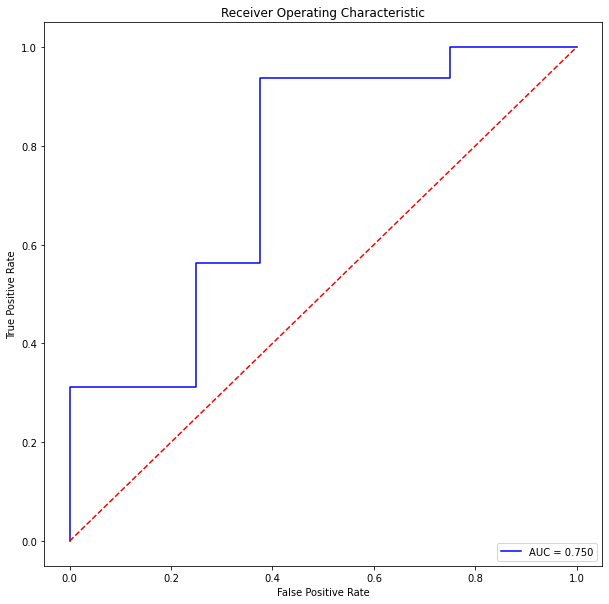

In [45]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(model_eval.sample_label,
                                         model_eval.mean_spectra_prediction)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.show()

Next, let's plot the precision-recall curve:

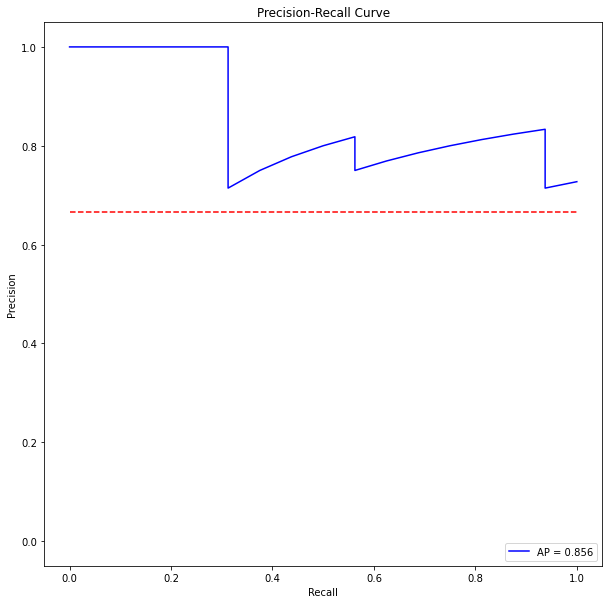

In [46]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
  model_eval.sample_label, model_eval.mean_spectra_prediction)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
  model_eval.sample_label, model_eval.mean_spectra_prediction
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(model_eval.sample_label==1) / len(model_eval.sample_label)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Precision-Recall Curve")
plt.show()

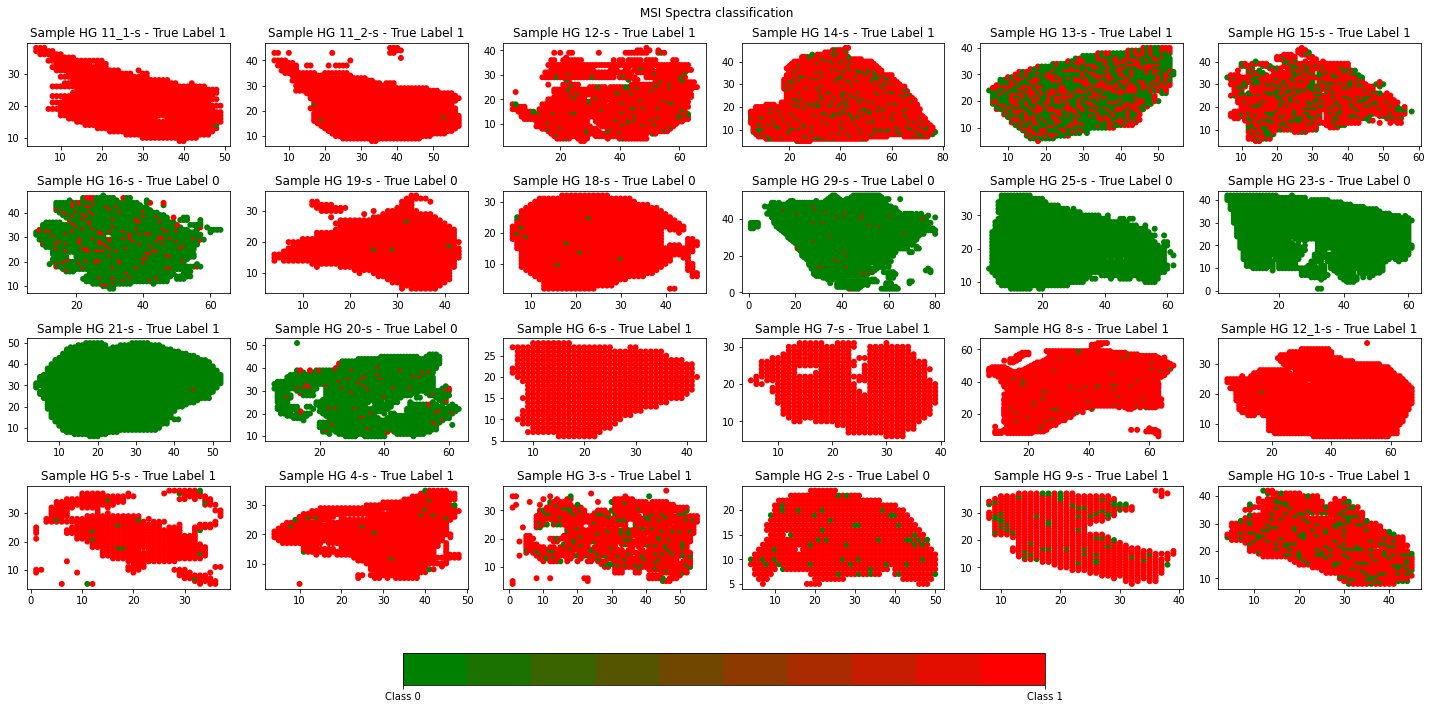

In [47]:
# Create custom binary color bar
colors = ["green", "red"]
cm = LinearSegmentedColormap.from_list("Class", colors, N=10)

# Create subplots
fig, axes = plt.subplots(4, 6, figsize=(20, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's predictions
  im = ax.scatter(x_coordinates[(file_names == key) & is_tissue],
                  y_coordinates[(file_names == key) & is_tissue],
                  c=predictions[key],
                  cmap=cm,
                  edgecolor=['none'],
                  vmin=0,
                  vmax=1,
                  linewidths=0)
  #
  ax.set_title(f"Sample {key} - True Label {true_labels[key][0]}")
# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("MSI Spectra classification")

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Add one color bar
cbar = fig.colorbar(im,
                    ax=axes.ravel().tolist(),
                    location="bottom",
                    orientation="horizontal",
                    fraction=0.05,
                    pad=0.10)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["Class 0", "Class 1"])

# Show plot
plt.show()

##### ***Evaluation on non tissue spectra's:***

Next, let's get the prediction of each of left out sample non tissue spectra's:

In [48]:
# Define dict for saving predictions and true labels
predictions = {}
true_labels = {}

# Loop over each sample number
for index, row in tqdm(metadata_df.iterrows(), total=metadata_df.shape[0],
                           desc="MSI Loop"):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Create filter for training data
  test_filter = ((file_names == row.sample_file_name) & ~is_tissue)

  # Get indexes of all data
  indexes = np.arange(len(sample_numbers))

  # Create test data generator
  test_generator = create_ds(indexes[test_filter], BATCH_SIZE, False)

  # Get saved model path
  model_path = os.path.join(
      '.', f"approach_2/excluded_{row.file_name}/"
  )

  # Load model
  classification_model = tf.keras.models.load_model(model_path)

  # Get predictions
  predictions[row.sample_file_name] = classification_model.predict(x=test_generator)

  # Get corresponding true labels
  true_labels[row.sample_file_name] = labels[test_filter]

  # Clean model for next iteration
  classification_model = None

MSI Loop: 100%|██████████| 24/24 [01:59<00:00,  4.97s/it]


Next, let's get some statistics about each left out sample predictions:

In [49]:
# Set pandas display format
pd.options.display.float_format = '{:.10f}'.format
# Create datafrmae of each sample left out
model_eval = pd.DataFrame({"sample_left_out": predictions.keys()})
# Get the minimum prediction value of each sample left out
model_eval["min_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].min())
# Get the maximum prediction value of each sample left out
model_eval["max_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].max())
# Get the median prediction value of each sample left out
model_eval["median_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: np.median(predictions[key]))
# Get the mean prediction value of each sample left out
model_eval["mean_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].mean())
# Get the standard deviation prediction value of each sample left out
model_eval["std_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].std())
# Get the sample prediction = majority rule of sample spectra's prediction
model_eval["sample_label"] = model_eval.sample_left_out.apply(
    lambda key: true_labels[key][0])
# Get the sample true label
model_eval["sample_prediction"] = (model_eval.mean_spectra_prediction >
                                   0.5).astype(int)
# Print statistics
model_eval

,sample_left_out,min_spectra_prediction,max_spectra_prediction,median_spectra_prediction,mean_spectra_prediction,std_spectra_prediction,sample_label,sample_prediction
0,HG 11_1-s,0.5560936928,0.9999954700,0.9997393489,0.9989457726,0.0129411295,1,1
1,HG 11_2-s,0.6489028931,0.9999963045,0.9998941422,0.9993113279,0.0101568392,1,1
2,HG 12-s,0.9850727916,0.9999998808,0.9998663664,0.9994108081,0.0011894651,1,1
3,HG 14-s,0.0000000012,0.9647002816,0.0000039128,0.0110109309,0.0680308864,1,0
4,HG 13-s,0.0000000006,0.5165932178,0.0000062420,0.0019195927,0.0186050739,1,0
5,HG 15-s,0.0022211242,0.2319695652,0.0254190248,0.0308160428,0.0204626340,1,0
6,HG 16-s,0.0033228116,0.2749224901,0.0360231064,0.0440007336,0.0320989974,0,0
7,HG 19-s,0.9991287589,0.9999645948,0.9999219179,0.9998881817,0.0000934224,0,1
8,HG 18-s,0.9991111159,0.9999606609,0.9998972416,0.9998413324,0.0001448467,0,1
9,HG 29-s,0.5171488523,0.5344548225,0.5268054008,0.5268467069,0.0020339151,0,1


Next, let's evaluate the classification performance:

In [50]:
# Get accuracy
accuracy = metrics.accuracy_score(model_eval.sample_label,
                                  model_eval.sample_prediction)
# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(model_eval.sample_label,
                                             model_eval.sample_prediction)
# Get precision
precision = metrics.precision_score(model_eval.sample_label,
                                    model_eval.sample_prediction)
# Get recall
recall = metrics.recall_score(model_eval.sample_label,
                              model_eval.sample_prediction)
# Get  f1 score
f1 = metrics.f1_score(model_eval.sample_label, model_eval.sample_prediction)

# Print metrics
print(f"Accuracy: {accuracy:.3f}")
print(f"Balanced  Accuracy: {b_accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 score: {f1:.3f}")

Accuracy: 0.333
Balanced  Accuracy: 0.312
Precision: 0.500
Recall: 0.375
F1 score: 0.429


Next, let's plot the roc curve:

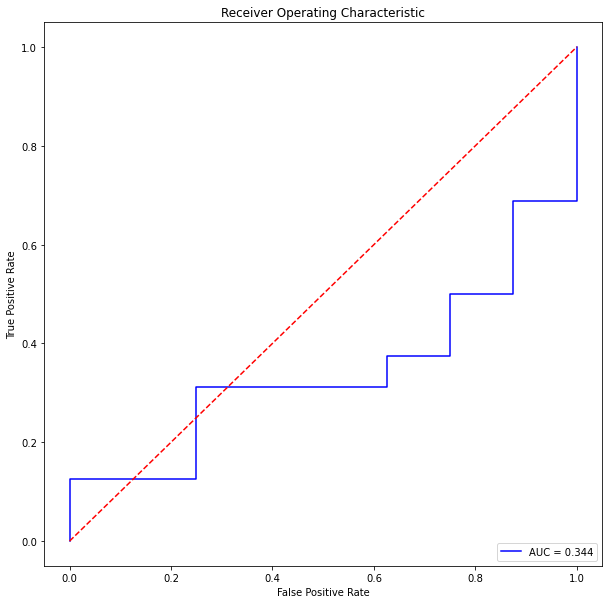

In [51]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(model_eval.sample_label,
                                         model_eval.mean_spectra_prediction)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.show()

Next, let's plot the precision-recall curve:

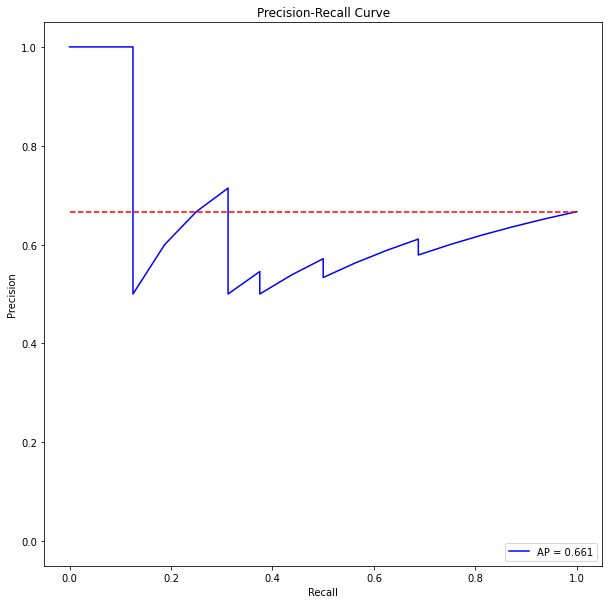

In [52]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
  model_eval.sample_label, model_eval.mean_spectra_prediction)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
  model_eval.sample_label, model_eval.mean_spectra_prediction
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(model_eval.sample_label==1) / len(model_eval.sample_label)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Precision-Recall Curve")
plt.show()

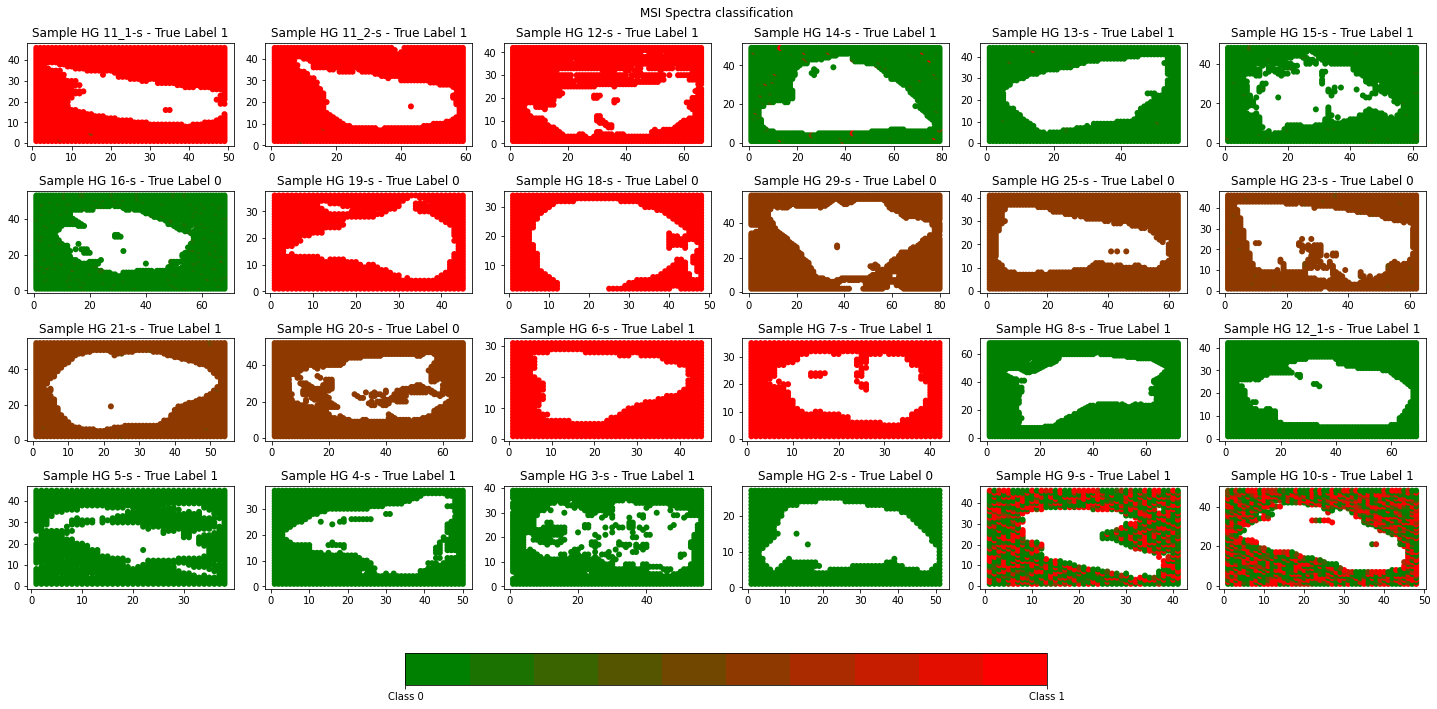

In [53]:
# Create custom binary color bar
colors = ["green", "red"]
cm = LinearSegmentedColormap.from_list("Class", colors, N=10)

# Create subplots
fig, axes = plt.subplots(4, 6, figsize=(20, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's predictions
  im = ax.scatter(x_coordinates[(file_names == key) & ~is_tissue],
                  y_coordinates[(file_names == key) & ~is_tissue],
                  c=predictions[key],
                  cmap=cm,
                  edgecolor=['none'],
                  vmin=0,
                  vmax=1,
                  linewidths=0)
  #
  ax.set_title(f"Sample {key} - True Label {true_labels[key][0]}")
# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("MSI Spectra classification")

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Add one color bar
cbar = fig.colorbar(im,
                    ax=axes.ravel().tolist(),
                    location="bottom",
                    orientation="horizontal",
                    fraction=0.05,
                    pad=0.10)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["Class 0", "Class 1"])

# Show plot
plt.show()

### ***MSI parsers closing:***

Next, let"s close MSI parsers:

In [54]:
# Closing parsers
for reader in parsers.values():
  if reader.m:
    reader.m.close()